In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE




pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%matplotlib inline

from graphviz import Source
from IPython.display import SVG, display, HTML
style = "<style>svg{width: 70% !important; height: 60% !important;} </style>"

In [2]:
def corr_matrix(df, var_list, var_n_limit = 0, abs_flag=0, method='pearson', corr_thresh = 0.6):
    """
    Построение матрицы корреляций;
    df: DF с переменными,
    var_list: список переменных, для которых строить матрицу,
    var_n_limit = 0: <=0 - вывести всю матрицы, иначе заданное количество переменных;
    abs_flag = 0: вывести корреляции как есть или абсолютные величины;
    method='pearson': коэффициент корреляции: pearson либо spearman;
    corr_thresh = 0.6: пороговое значение (от него зависит раскраска матрицы);
    """
    corr = df[var_list].corr(method=method).round(2)
    if var_n_limit <= 0:
        corr_shrinked = corr
    else:
        corr_shrinked = df[var_list[:var_n_limit]].corr(method=method)
    if abs_flag==1:
        corr = abs(corr)
        corr_shrinked = abs(corr_shrinked)
        center_param = corr_thresh
    else:
        center_param = 0
    mask = np.triu(np.ones_like(corr_shrinked, dtype=bool), 1)
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr_shrinked, mask=mask, cmap=cmap, vmin=0, vmax=1, center=center_param,
            square=True, annot=True, linewidths=1, cbar_kws={"shrink": 1})
    plt.show()
    return corr

In [3]:
def metrics_calc(clf, X, y_true):
    '''
    Расчет gini и accuracy
    
    clf: модель
    X: выборка
    y_true: столбец с целевой переменной взятый из выборки
    
    '''
    
    y_predicted = clf.predict(X)

    gini = 2*roc_auc_score(y_true, y_predicted) - 1
    accuracy = clf.score(X, y_true)
    return {'gini': round(gini, 2), 'accuracy': round(accuracy, 2)}

In [4]:
def calc_var_gini(X, Y):
    """Процедура расчёта коэффициента Джини для списка объясняющих переменных и заданной целевой"""
    from sklearn.metrics import roc_auc_score
    df_tmp = pd.DataFrame()
    var_list=[]
    gini_list=[]
    for i in X.columns:
        x = X[i]
        try:
            gini = 2*roc_auc_score(Y, x) - 1
            gini_list.append(gini)
            var_list.append(i)
        except:
            pass
    df_tmp['variable']=var_list
    df_tmp['gini']=gini_list
    df_tmp['gini_abs']=abs(df_tmp['gini'])
    return df_tmp

In [5]:
data = pd.read_table("abt_em.tab")
data.tail(5)
#data.isnull()

,customerID,atm_trn_cnt_1,atm_trn_cnt,bt_trn_cnt_1,bt_trn_cnt,chq_trn_cnt_1,chq_trn_cnt,cc_trn_cnt_1,cc_trn_cnt,elt_trn_cnt_1,elt_trn_cnt,ht_trn_cnt_1,ht_trn_cnt,it_trn_cnt,it_trn_cnt_1,pos_trn_cnt_1,pos_trn_cnt,trd_trn_cnt_1,trd_trn_cnt,cc_clos,acc_credit,acc_funds,arrear_ind,cc_appr_amt,cc_avg_bal,cc_avg_bal_1,cc_min_bal,chq_acc_ind,cust_age,days_brtday,cc_ea_open_mth,sa_ea_open_mth,tr_ea_open_mth,enq_trn_cnt,equity_amt,gender,recency,fol_l_clos_mth,fol_l_open_mth,reject,sa_la_clos_mth,sa_la_open_mth,tr_la_clos_mth,tr_la_open_mth,cust_class,dep_max_amt,ch_addr,ch_marital,npv_savings,npv_trans,depos_count,joint_acc_cnt,prod_count,sav_acc_count,tra_acc_count,wthdr_count,avg_bal,title,eqity_secur,rel_age,sav_avg_bal_1,sav_avg_bal,avg_bal_1,npv_total,tra_avg_bal_1,tra_avg_bal,tr_min_bal,tra_auth_no,tra_auth_yes,call_enq_cnt,call_trn_cnt_1,call_trn_cnt,Change_In_ATM_TR
4253,3010910,9,2,9,3,10,4,24,31,34,35,13,25,1,10,10,2,6,7,0,270000,270000.00,N,5000,-1840.67,-1853,-1068.59,Y,41,191,24,-1,-1,23,-260149.55,M,24,-1,24,-1,-1,-1,-1,-1,10,1924.29,-1,-1,0.00,0.00,8,1,2,0,0,41,-259460.59,MR,0.0,27,0,0.00,-259453,6635.77,0,0.00,0.00,-1,-1,0,0,0,-77.777778
4254,1142196,23,3,18,5,0,0,10,5,32,31,0,0,0,0,29,23,18,5,0,15500,21335.38,N,5500,-5162.20,-5181,-4990.41,N,41,61,116,48,170,0,-5875.96,M,48,59,58,-1,22,48,70,117,8,1496.00,8,-1,0.00,304.50,4,1,3,0,1,35,753.72,MR,0.0,167,0,0.00,757,639.00,6796,6781.59,5835.38,-1,-1,0,0,0,-86.956522
4255,4695416,7,1,10,6,0,0,3,8,10,13,0,0,0,0,9,3,10,6,0,267000,269741.48,N,2000,-1544.39,-1545,-898.24,Y,31,210,19,93,103,0,251200.80,F,16,20,18,-1,7,93,-1,16,4,2044.00,-1,-1,0.00,-502.10,7,3,3,0,4,14,-250736.16,MISS,0.5,101,0,0.00,-250715,3931.03,2837,2821.27,952.03,-1,-1,0,0,0,-85.714286
4256,1007358,10,7,10,2,13,1,10,6,25,43,10,5,0,0,20,30,5,3,0,3000,111207.98,N,3000,-475.01,-489,-267.94,Y,43,52,47,1,105,3,-488.01,M,1,1,62,-1,-1,1,-1,61,30,870.00,-1,-1,2888.62,-47.39,10,1,3,1,2,44,107563.26,MR,0.0,103,105997,106097.95,107549,2829.80,1950,1940.32,967.01,-1,-1,0,6,0,-30.000000
4257,2871816,0,0,10,1,0,0,10,3,10,3,0,0,0,0,0,0,10,1,0,1000,1000.00,N,2000,-49.54,-51,0.65,N,40,171,131,-1,-1,0,-72.46,F,27,-1,-1,-1,-1,-1,-1,-1,12,851.00,-1,-1,0.00,0.00,2,0,1,0,0,2,-49.54,MISS,0.0,129,0,0.00,-51,-11.43,0,0.00,0.00,-1,-1,0,0,0,NaN


## Подготовка датасета

In [7]:
y = data['cc_clos']
X = data.drop(['cc_clos', 'customerID', 'title'], axis=1)
X = X.fillna(0)
X = X.replace({'F': 0, 'M': 1, 'N': 0, 'Y': 1, 'U': 2})

In [8]:
print('Закрытий кредитной карты в следующем месяце во всей выборке:', y.sum())
print('Всего клиентов во всей выборке:', y.shape[0])
print('Процент закрытий кредитной карты в следующем месяце во всей выборке:', round(y.sum()/y.shape[0] * 100, 2),'%')
print('Вывод: выборка несбалансированная!')

Закрытий кредитной карты в следующем месяце во всей выборке: 197
Всего клиентов во всей выборке: 4258
Процент закрытий кредитной карты в следующем месяце во всей выборке: 4.63 %
Вывод: выборка несбалансированная!


In [9]:
# разбиение выборки на Train и Test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

## Решающий лес. Baseline.

In [10]:
clf_rf = RandomForestClassifier(max_depth=15, max_features='sqrt', n_estimators=100, random_state=0)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, max_features='sqrt', random_state=0)

In [11]:
# Расчет gini и accuracy на train и test выборках

print("Метрики на Train выборке:", metrics_calc(clf_rf, X_train, y_train))
print("Метрики на Test выборке:", metrics_calc(clf_rf, X_test, y_test))

Метрики на Train выборке: {'gini': 0.98, 'accuracy': 1.0}
Метрики на Test выборке: {'gini': 0.34, 'accuracy': 0.97}


<AxesSubplot:>

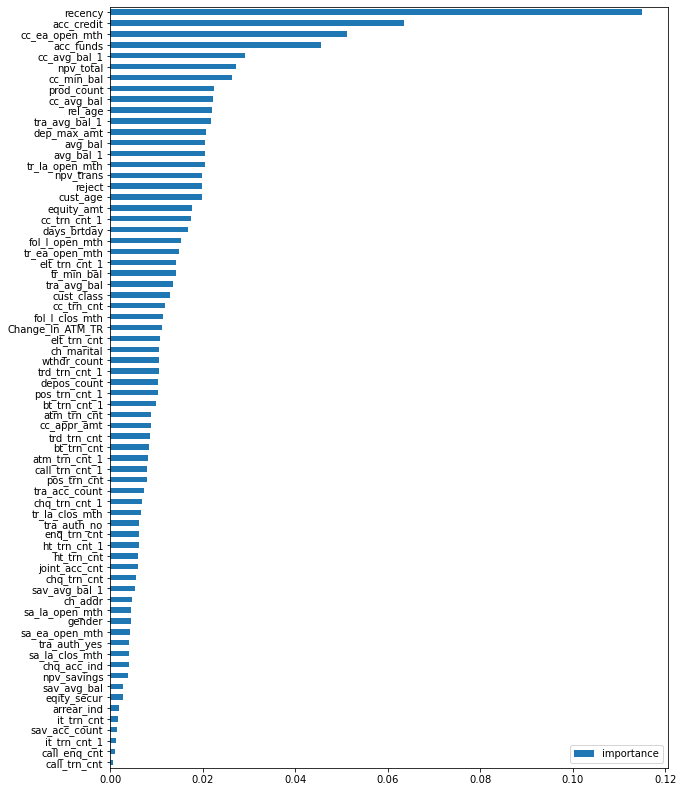

In [368]:
#вес фичей в алгоритме, добавлен из любопытства

imp = pd.DataFrame(clf_rf.feature_importances_, index=X_train.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(10, 14))

## Попытка перебрать гиперпараметры модели, чтобы подобрать оптимальную

In [17]:
# настройка гиперпараметров модели

parameters = {'criterion':['entropy','gini'], 
              'max_depth': range(1,20,2),
              'n_estimators': range(100,300,50)}
grid_search_cv_clf = GridSearchCV(clf_rf, parameters, cv = 5)

In [18]:
%%time
grid_search_cv_clf.fit(X_train, y_train)

Wall time: 6min 43s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, max_features='sqrt',
                                              random_state=0),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 20, 2),
                         'n_estimators': range(100, 300, 50)})

## Выберем лучший решающий лес и обучим его 

In [19]:
print('Параметры лучшей модели:' ,grid_search_cv_clf.best_params_)

Параметры лучшей модели: {'criterion': 'gini', 'max_depth': 19, 'n_estimators': 200}


In [34]:
# Попробуем обучить лучшую модель и посмотрим вырос ли gini

best_random_forest = RandomForestClassifier(max_depth=19, max_features='sqrt', n_estimators=200, random_state=0)
best_random_forest.fit(X_train, y_train)
 

RandomForestClassifier(max_depth=19, max_features='sqrt', n_estimators=200,
                       random_state=0)

In [35]:
# Расчет gini и accuracy на train и test выборках для лучшей модели

print("Метрики на Train выборке:", metrics_calc(clf_rf, X_train, y_train))
print("Метрики на Test выборке:", metrics_calc(clf_rf, X_test, y_test))

Метрики на Train выборке: {'gini': 0.98, 'accuracy': 1.0}
Метрики на Test выборке: {'gini': 0.34, 'accuracy': 0.97}


### Промежуточные выводы
#### Был были обучены две модели RandomForest Baseline и RandomForest Best
#### Значение целевой метрики качества модели gini не отличается для этих двух моделей и равно 0.34

##### Это плохо. В чем может быть проблема? 
1) В тестовой выборке многие столбцы линейно-зависимы

2) Выборка несбалансированная 

3) Решающий лес неподходящий алгоритм для такой задачи

##### Что можно сделать?
1) Более качественно подготовить выборку

2) Использовать другие модели: решаюшее дерево, логистическую регрессию

3) Можно попробовать использовать градиентный бустинг

## Воспользуемся корреляционной матрицей, чтобы найти линейно-зависимые столбцы в выборке и удалим их

<ipython-input-22-187b7920fbba>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))


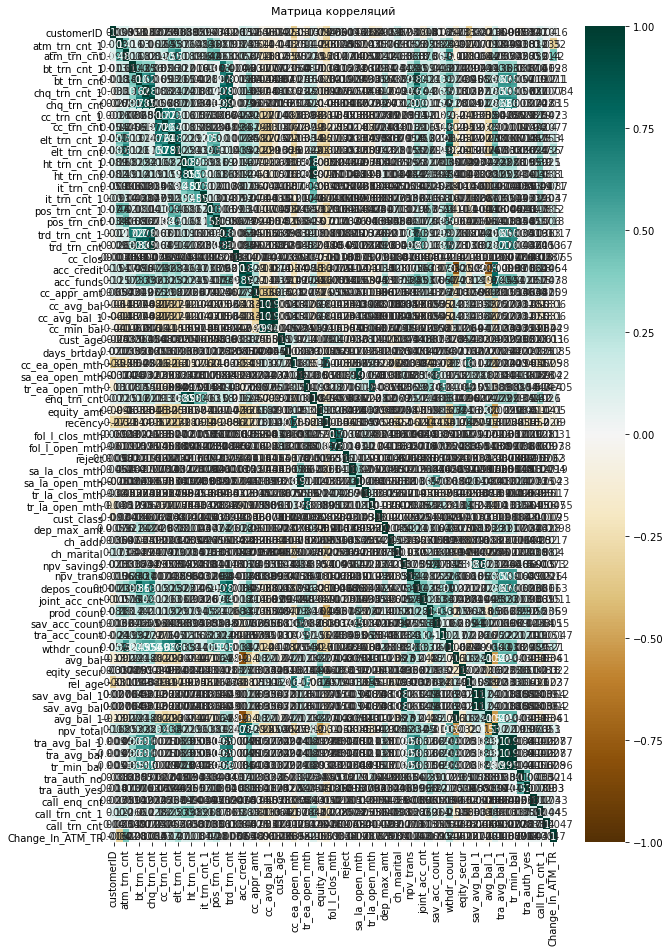

In [22]:
%%time

#определим признаки, с коэф-м выше порога
corr_df = data.corr()
threshold = 0.6
file_name = 'mattrx_corr'
upper = corr_df.where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

#delete columns

# df_spark = df_spark.drop(*to_drop)



fig = plt.figure(figsize=(10, 15))

dataplot = sns.heatmap(corr_df,vmin=-1,vmax=1, annot=True, cmap='BrBG')

dataplot.set_title(f'Матрица корреляций', fontdict={'fontsize':11}, pad=12)



plt.savefig(f'{file_name}.png', dpi=300, bbox_inches='tight')

In [23]:
to_drop # линейно-зависимые столбцы, которые можно выкинуть из выборки

['chq_trn_cnt_1',
 'chq_trn_cnt',
 'cc_trn_cnt',
 'elt_trn_cnt_1',
 'elt_trn_cnt',
 'ht_trn_cnt',
 'trd_trn_cnt_1',
 'trd_trn_cnt',
 'acc_funds',
 'cc_avg_bal_1',
 'cc_min_bal',
 'enq_trn_cnt',
 'recency',
 'fol_l_open_mth',
 'sa_la_open_mth',
 'tr_la_open_mth',
 'depos_count',
 'sav_acc_count',
 'wthdr_count',
 'rel_age',
 'sav_avg_bal_1',
 'sav_avg_bal',
 'avg_bal_1',
 'npv_total',
 'tra_avg_bal_1',
 'tra_avg_bal',
 'tr_min_bal']

#### Считаем gini для каждой переменной и выкидываем из датасэта все переменные у которых gini меньше 0.1

In [25]:
df_gini = calc_var_gini(data.drop(['cc_clos'], axis=1), data.cc_clos)

In [26]:
df_gini.sort_values(['gini_abs'], ascending=False)
best_gini = df_gini[df_gini['gini_abs']>0.1].sort_values(['gini_abs'])

In [27]:
lst = list(best_gini['variable'])
clean_df = data[lst]

In [28]:
clean_df.head()

,acc_credit,cc_min_bal,cc_trn_cnt,cc_avg_bal,cc_appr_amt,prod_count,cc_avg_bal_1,recency
0,500,0.40,0,0.40,2000,2,0,22
1,3000,0.99,0,0.99,3000,2,18,21
2,2000,-483.36,10,-1795.43,2000,1,-1791,84
3,67000,0.00,1,-58.91,2000,3,-77,16
4,7500,-1704.89,0,-1715.46,2000,3,-1717,11


In [32]:
X_clean_train, X_clean_test, y_train, y_test = train_test_split(clean_df, y, test_size=0.30, random_state=1)

In [36]:
best_random_forest.fit(X_clean_train, y_train) # обучим лучшую модель, которая была подобрана на сетке гиперпараметров 
                                               # из прошлой на начальной, неочищенной выборке

RandomForestClassifier(max_depth=19, max_features='sqrt', n_estimators=200,
                       random_state=0)

In [39]:
# Расчет gini и accuracy на train и test выборках датасета clean_df очищенного от фичей с низким gini

print("Метрики на Train_clean выборке:", metrics_calc(best_random_forest, X_clean_train, y_train))
print("Метрики на Test_clean выборке:", metrics_calc(best_random_forest, X_clean_test, y_test))
print("Использование очищенной выборки увеличило gini на 0.09")

Метрики на Train_clean выборке: {'gini': 0.97, 'accuracy': 1.0}
Метрики на Test_clean выборке: {'gini': 0.43, 'accuracy': 0.97}
Использование очищенной выборки увеличило gini на 0.09


In [45]:
# настройка гиперпараметров модели на датасэте clean_df
# попробуем найти лучшую модель обучая модели на очищенном датасэте
parameters = {'criterion':['entropy','gini'], 
              'max_depth': range(1,20,2),
              'n_estimators': range(100,300,50)}
clean_grid_search_cv = GridSearchCV(clf_rf, parameters, cv = 5)

In [46]:
%%time
clean_grid_search_cv.fit(X_clean_train, y_train)

Wall time: 3min 23s


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=15, max_features='sqrt',
                                              random_state=0),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(1, 20, 2),
                         'n_estimators': range(100, 300, 50)})

In [47]:
# сохраним лучшую модель подобранную на очищенной выборке 
print(clean_grid_search_cv.best_estimator_)
best_clean_estimator = clean_grid_search_cv.best_estimator_.fit(X_clean_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=13, max_features='sqrt',
                       n_estimators=200, random_state=0)


In [48]:
# Расчет gini и accuracy на train и test выборках датасета clean_df очищенного от фичей с низким gini

print("Метрики на Train_clean выборке:", metrics_calc(best_clean_estimator, X_clean_train, y_train))
print("Метрики на Test_clean выборке:", metrics_calc(best_clean_estimator, X_clean_test, y_test))

Метрики на Train_clean выборке: {'gini': 0.96, 'accuracy': 1.0}
Метрики на Test_clean выборке: {'gini': 0.43, 'accuracy': 0.97}


#### Промежуточный вывод: очистка выборки помогла нам увеличить gini до 0.43. Подбор гиперпараметров на очищенной выборке не дал никаких результатов.

## Попробуем использовать градиентный бустинг на решающих деревьях. Воспользуемся библиотекой catboost. Цель: достичь значения gini на тестовой выборке более 0.6.

In [55]:
cb_clf = CatBoostClassifier(depth=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [60]:
%%time
boost_clean_data = cb_clf.fit(X_clean_train, y_train)

Learning rate set to 0.016422
0:	learn: 0.6698354	total: 3.45ms	remaining: 3.45s
1:	learn: 0.6473981	total: 6.63ms	remaining: 3.31s
2:	learn: 0.6254760	total: 10.4ms	remaining: 3.47s
3:	learn: 0.6007207	total: 13.7ms	remaining: 3.42s
4:	learn: 0.5819946	total: 16.8ms	remaining: 3.34s
5:	learn: 0.5603442	total: 20.6ms	remaining: 3.42s
6:	learn: 0.5417251	total: 24.1ms	remaining: 3.42s
7:	learn: 0.5251561	total: 27.9ms	remaining: 3.45s
8:	learn: 0.5072773	total: 31.1ms	remaining: 3.43s
9:	learn: 0.4928785	total: 34.7ms	remaining: 3.44s
10:	learn: 0.4789541	total: 37.8ms	remaining: 3.4s
11:	learn: 0.4630449	total: 41ms	remaining: 3.37s
12:	learn: 0.4500114	total: 44.4ms	remaining: 3.37s
13:	learn: 0.4331648	total: 47.8ms	remaining: 3.37s
14:	learn: 0.4208796	total: 52.7ms	remaining: 3.46s
15:	learn: 0.4092649	total: 57.3ms	remaining: 3.52s
16:	learn: 0.3991047	total: 61.8ms	remaining: 3.58s
17:	learn: 0.3855448	total: 66.7ms	remaining: 3.64s
18:	learn: 0.3766529	total: 72.4ms	remaining: 3

166:	learn: 0.0874250	total: 528ms	remaining: 2.63s
167:	learn: 0.0872590	total: 531ms	remaining: 2.63s
168:	learn: 0.0871168	total: 534ms	remaining: 2.63s
169:	learn: 0.0869288	total: 538ms	remaining: 2.63s
170:	learn: 0.0867035	total: 541ms	remaining: 2.62s
171:	learn: 0.0864478	total: 544ms	remaining: 2.62s
172:	learn: 0.0863655	total: 548ms	remaining: 2.62s
173:	learn: 0.0861253	total: 552ms	remaining: 2.62s
174:	learn: 0.0859771	total: 556ms	remaining: 2.62s
175:	learn: 0.0857656	total: 559ms	remaining: 2.62s
176:	learn: 0.0855888	total: 562ms	remaining: 2.61s
177:	learn: 0.0854505	total: 565ms	remaining: 2.61s
178:	learn: 0.0853000	total: 568ms	remaining: 2.6s
179:	learn: 0.0851411	total: 572ms	remaining: 2.61s
180:	learn: 0.0849607	total: 575ms	remaining: 2.6s
181:	learn: 0.0848592	total: 578ms	remaining: 2.6s
182:	learn: 0.0846723	total: 581ms	remaining: 2.59s
183:	learn: 0.0844288	total: 584ms	remaining: 2.59s
184:	learn: 0.0842546	total: 587ms	remaining: 2.58s
185:	learn: 0.0

344:	learn: 0.0676696	total: 1.06s	remaining: 2.01s
345:	learn: 0.0675519	total: 1.06s	remaining: 2.01s
346:	learn: 0.0674898	total: 1.07s	remaining: 2.01s
347:	learn: 0.0674333	total: 1.07s	remaining: 2s
348:	learn: 0.0673986	total: 1.07s	remaining: 2s
349:	learn: 0.0673313	total: 1.08s	remaining: 2s
350:	learn: 0.0672923	total: 1.08s	remaining: 2s
351:	learn: 0.0672442	total: 1.08s	remaining: 1.99s
352:	learn: 0.0671709	total: 1.08s	remaining: 1.99s
353:	learn: 0.0670973	total: 1.09s	remaining: 1.99s
354:	learn: 0.0669986	total: 1.09s	remaining: 1.99s
355:	learn: 0.0669034	total: 1.09s	remaining: 1.98s
356:	learn: 0.0668428	total: 1.1s	remaining: 1.98s
357:	learn: 0.0667643	total: 1.1s	remaining: 1.97s
358:	learn: 0.0667440	total: 1.1s	remaining: 1.97s
359:	learn: 0.0666743	total: 1.11s	remaining: 1.97s
360:	learn: 0.0665918	total: 1.11s	remaining: 1.96s
361:	learn: 0.0665343	total: 1.11s	remaining: 1.96s
362:	learn: 0.0664639	total: 1.11s	remaining: 1.96s
363:	learn: 0.0664148	total

513:	learn: 0.0579128	total: 1.59s	remaining: 1.5s
514:	learn: 0.0578298	total: 1.59s	remaining: 1.5s
515:	learn: 0.0577667	total: 1.6s	remaining: 1.5s
516:	learn: 0.0577234	total: 1.6s	remaining: 1.49s
517:	learn: 0.0576902	total: 1.6s	remaining: 1.49s
518:	learn: 0.0576265	total: 1.61s	remaining: 1.49s
519:	learn: 0.0575623	total: 1.61s	remaining: 1.49s
520:	learn: 0.0575104	total: 1.61s	remaining: 1.48s
521:	learn: 0.0574896	total: 1.62s	remaining: 1.48s
522:	learn: 0.0574051	total: 1.62s	remaining: 1.48s
523:	learn: 0.0573818	total: 1.62s	remaining: 1.47s
524:	learn: 0.0572953	total: 1.63s	remaining: 1.47s
525:	learn: 0.0572767	total: 1.63s	remaining: 1.47s
526:	learn: 0.0572270	total: 1.63s	remaining: 1.46s
527:	learn: 0.0571897	total: 1.63s	remaining: 1.46s
528:	learn: 0.0571740	total: 1.64s	remaining: 1.46s
529:	learn: 0.0570583	total: 1.64s	remaining: 1.45s
530:	learn: 0.0570047	total: 1.64s	remaining: 1.45s
531:	learn: 0.0569508	total: 1.65s	remaining: 1.45s
532:	learn: 0.0569

684:	learn: 0.0504534	total: 2.12s	remaining: 973ms
685:	learn: 0.0504466	total: 2.12s	remaining: 970ms
686:	learn: 0.0504330	total: 2.12s	remaining: 967ms
687:	learn: 0.0504263	total: 2.13s	remaining: 964ms
688:	learn: 0.0503801	total: 2.13s	remaining: 961ms
689:	learn: 0.0503513	total: 2.13s	remaining: 959ms
690:	learn: 0.0503017	total: 2.14s	remaining: 956ms
691:	learn: 0.0502547	total: 2.14s	remaining: 953ms
692:	learn: 0.0502087	total: 2.14s	remaining: 950ms
693:	learn: 0.0501760	total: 2.15s	remaining: 947ms
694:	learn: 0.0501334	total: 2.15s	remaining: 943ms
695:	learn: 0.0500538	total: 2.15s	remaining: 940ms
696:	learn: 0.0499897	total: 2.15s	remaining: 937ms
697:	learn: 0.0499577	total: 2.16s	remaining: 934ms
698:	learn: 0.0499469	total: 2.16s	remaining: 931ms
699:	learn: 0.0499363	total: 2.16s	remaining: 928ms
700:	learn: 0.0499023	total: 2.17s	remaining: 924ms
701:	learn: 0.0498720	total: 2.17s	remaining: 921ms
702:	learn: 0.0498510	total: 2.17s	remaining: 918ms
703:	learn: 

863:	learn: 0.0450949	total: 2.65s	remaining: 417ms
864:	learn: 0.0450856	total: 2.65s	remaining: 414ms
865:	learn: 0.0450682	total: 2.65s	remaining: 411ms
866:	learn: 0.0450351	total: 2.66s	remaining: 408ms
867:	learn: 0.0449933	total: 2.66s	remaining: 405ms
868:	learn: 0.0449718	total: 2.67s	remaining: 402ms
869:	learn: 0.0449469	total: 2.67s	remaining: 399ms
870:	learn: 0.0448771	total: 2.67s	remaining: 396ms
871:	learn: 0.0448340	total: 2.68s	remaining: 393ms
872:	learn: 0.0448150	total: 2.68s	remaining: 390ms
873:	learn: 0.0447894	total: 2.68s	remaining: 387ms
874:	learn: 0.0447718	total: 2.68s	remaining: 384ms
875:	learn: 0.0447242	total: 2.69s	remaining: 380ms
876:	learn: 0.0447038	total: 2.69s	remaining: 377ms
877:	learn: 0.0446711	total: 2.69s	remaining: 374ms
878:	learn: 0.0446305	total: 2.7s	remaining: 371ms
879:	learn: 0.0446215	total: 2.7s	remaining: 368ms
880:	learn: 0.0445790	total: 2.7s	remaining: 365ms
881:	learn: 0.0445549	total: 2.71s	remaining: 362ms
882:	learn: 0.0

In [61]:
print("Метрики на Train_clean выборке при градиентном бустинге:", metrics_calc(boost_clean_data, X_clean_train, y_train))
print("Метрики на Test_clean выборке при градиентном бустинге:", metrics_calc(boost_clean_data, X_clean_test, y_test))

Метрики на Train_clean выборке при градиентном бустинге: {'gini': 0.76, 'accuracy': 0.99}
Метрики на Test_clean выборке при градиентном бустинге: {'gini': 0.46, 'accuracy': 0.97}


In [63]:
boost_not_clean_data = cb_clf.fit(X_train, y_train)

Learning rate set to 0.016422
0:	learn: 0.6709027	total: 9.3ms	remaining: 9.29s
1:	learn: 0.6494070	total: 17.7ms	remaining: 8.84s
2:	learn: 0.6288648	total: 25.2ms	remaining: 8.36s
3:	learn: 0.6093543	total: 32.7ms	remaining: 8.13s
4:	learn: 0.5908139	total: 46.3ms	remaining: 9.21s
5:	learn: 0.5725817	total: 55.2ms	remaining: 9.14s
6:	learn: 0.5554536	total: 61.8ms	remaining: 8.77s
7:	learn: 0.5366660	total: 68.3ms	remaining: 8.47s
8:	learn: 0.5208256	total: 75ms	remaining: 8.25s
9:	learn: 0.5062565	total: 80.9ms	remaining: 8.01s
10:	learn: 0.4919199	total: 87.2ms	remaining: 7.84s
11:	learn: 0.4726052	total: 93.1ms	remaining: 7.66s
12:	learn: 0.4598856	total: 99ms	remaining: 7.52s
13:	learn: 0.4479829	total: 105ms	remaining: 7.38s
14:	learn: 0.4363786	total: 111ms	remaining: 7.28s
15:	learn: 0.4253323	total: 117ms	remaining: 7.19s
16:	learn: 0.4119045	total: 123ms	remaining: 7.11s
17:	learn: 0.3992941	total: 129ms	remaining: 7.06s
18:	learn: 0.3899550	total: 135ms	remaining: 6.98s
19:

177:	learn: 0.0816357	total: 1.28s	remaining: 5.9s
178:	learn: 0.0814306	total: 1.29s	remaining: 5.91s
179:	learn: 0.0811216	total: 1.3s	remaining: 5.91s
180:	learn: 0.0810752	total: 1.31s	remaining: 5.92s
181:	learn: 0.0809305	total: 1.32s	remaining: 5.93s
182:	learn: 0.0808974	total: 1.33s	remaining: 5.92s
183:	learn: 0.0808747	total: 1.34s	remaining: 5.94s
184:	learn: 0.0804274	total: 1.34s	remaining: 5.93s
185:	learn: 0.0804059	total: 1.35s	remaining: 5.93s
186:	learn: 0.0803707	total: 1.36s	remaining: 5.93s
187:	learn: 0.0802860	total: 1.37s	remaining: 5.93s
188:	learn: 0.0800944	total: 1.38s	remaining: 5.92s
189:	learn: 0.0798721	total: 1.39s	remaining: 5.92s
190:	learn: 0.0797487	total: 1.4s	remaining: 5.92s
191:	learn: 0.0796357	total: 1.4s	remaining: 5.91s
192:	learn: 0.0795607	total: 1.41s	remaining: 5.9s
193:	learn: 0.0792153	total: 1.42s	remaining: 5.9s
194:	learn: 0.0787801	total: 1.43s	remaining: 5.89s
195:	learn: 0.0787295	total: 1.44s	remaining: 5.89s
196:	learn: 0.0783

336:	learn: 0.0627914	total: 2.59s	remaining: 5.09s
337:	learn: 0.0626238	total: 2.6s	remaining: 5.09s
338:	learn: 0.0625373	total: 2.61s	remaining: 5.09s
339:	learn: 0.0625081	total: 2.62s	remaining: 5.09s
340:	learn: 0.0623644	total: 2.63s	remaining: 5.09s
341:	learn: 0.0622396	total: 2.65s	remaining: 5.11s
342:	learn: 0.0621074	total: 2.68s	remaining: 5.13s
343:	learn: 0.0619809	total: 2.69s	remaining: 5.13s
344:	learn: 0.0618314	total: 2.7s	remaining: 5.13s
345:	learn: 0.0618176	total: 2.71s	remaining: 5.12s
346:	learn: 0.0617482	total: 2.72s	remaining: 5.11s
347:	learn: 0.0617085	total: 2.73s	remaining: 5.11s
348:	learn: 0.0616480	total: 2.73s	remaining: 5.09s
349:	learn: 0.0615577	total: 2.74s	remaining: 5.08s
350:	learn: 0.0614916	total: 2.74s	remaining: 5.07s
351:	learn: 0.0614433	total: 2.75s	remaining: 5.06s
352:	learn: 0.0614126	total: 2.76s	remaining: 5.05s
353:	learn: 0.0613859	total: 2.76s	remaining: 5.04s
354:	learn: 0.0613368	total: 2.77s	remaining: 5.04s
355:	learn: 0.

498:	learn: 0.0513686	total: 3.9s	remaining: 3.91s
499:	learn: 0.0512972	total: 3.9s	remaining: 3.9s
500:	learn: 0.0512099	total: 3.91s	remaining: 3.9s
501:	learn: 0.0511254	total: 3.92s	remaining: 3.89s
502:	learn: 0.0510740	total: 3.93s	remaining: 3.88s
503:	learn: 0.0510595	total: 3.94s	remaining: 3.87s
504:	learn: 0.0510436	total: 3.94s	remaining: 3.86s
505:	learn: 0.0509880	total: 3.95s	remaining: 3.85s
506:	learn: 0.0509650	total: 3.96s	remaining: 3.85s
507:	learn: 0.0509450	total: 3.96s	remaining: 3.84s
508:	learn: 0.0509162	total: 3.97s	remaining: 3.83s
509:	learn: 0.0508799	total: 3.98s	remaining: 3.82s
510:	learn: 0.0508672	total: 3.98s	remaining: 3.81s
511:	learn: 0.0507492	total: 3.99s	remaining: 3.8s
512:	learn: 0.0507374	total: 4s	remaining: 3.79s
513:	learn: 0.0506936	total: 4s	remaining: 3.79s
514:	learn: 0.0506770	total: 4.01s	remaining: 3.78s
515:	learn: 0.0505455	total: 4.02s	remaining: 3.77s
516:	learn: 0.0505321	total: 4.03s	remaining: 3.76s
517:	learn: 0.0505132	t

675:	learn: 0.0423756	total: 5.19s	remaining: 2.48s
676:	learn: 0.0423598	total: 5.2s	remaining: 2.48s
677:	learn: 0.0423039	total: 5.2s	remaining: 2.47s
678:	learn: 0.0422202	total: 5.21s	remaining: 2.46s
679:	learn: 0.0421732	total: 5.22s	remaining: 2.46s
680:	learn: 0.0421450	total: 5.23s	remaining: 2.45s
681:	learn: 0.0421150	total: 5.24s	remaining: 2.44s
682:	learn: 0.0419923	total: 5.25s	remaining: 2.44s
683:	learn: 0.0419669	total: 5.25s	remaining: 2.43s
684:	learn: 0.0418482	total: 5.26s	remaining: 2.42s
685:	learn: 0.0416880	total: 5.27s	remaining: 2.41s
686:	learn: 0.0415983	total: 5.28s	remaining: 2.4s
687:	learn: 0.0415579	total: 5.29s	remaining: 2.4s
688:	learn: 0.0415287	total: 5.3s	remaining: 2.39s
689:	learn: 0.0414513	total: 5.3s	remaining: 2.38s
690:	learn: 0.0414458	total: 5.31s	remaining: 2.38s
691:	learn: 0.0413868	total: 5.32s	remaining: 2.37s
692:	learn: 0.0413829	total: 5.33s	remaining: 2.36s
693:	learn: 0.0413309	total: 5.33s	remaining: 2.35s
694:	learn: 0.0412

850:	learn: 0.0360961	total: 6.48s	remaining: 1.13s
851:	learn: 0.0360340	total: 6.49s	remaining: 1.13s
852:	learn: 0.0359889	total: 6.5s	remaining: 1.12s
853:	learn: 0.0359130	total: 6.52s	remaining: 1.11s
854:	learn: 0.0359092	total: 6.52s	remaining: 1.11s
855:	learn: 0.0358993	total: 6.53s	remaining: 1.1s
856:	learn: 0.0358757	total: 6.54s	remaining: 1.09s
857:	learn: 0.0358623	total: 6.55s	remaining: 1.08s
858:	learn: 0.0358545	total: 6.55s	remaining: 1.07s
859:	learn: 0.0358304	total: 6.56s	remaining: 1.07s
860:	learn: 0.0357978	total: 6.57s	remaining: 1.06s
861:	learn: 0.0357048	total: 6.57s	remaining: 1.05s
862:	learn: 0.0356262	total: 6.58s	remaining: 1.04s
863:	learn: 0.0355002	total: 6.58s	remaining: 1.04s
864:	learn: 0.0354436	total: 6.59s	remaining: 1.03s
865:	learn: 0.0354211	total: 6.6s	remaining: 1.02s
866:	learn: 0.0353654	total: 6.6s	remaining: 1.01s
867:	learn: 0.0353141	total: 6.61s	remaining: 1s
868:	learn: 0.0352899	total: 6.61s	remaining: 997ms
869:	learn: 0.03527

In [64]:
print("Метрики на Train выборке при градиентном бустинге:", metrics_calc(boost_not_clean_data , X_train, y_train))
print("Метрики на Test выборке при градиентном бустинге:", metrics_calc(boost_not_clean_data , X_test, y_test))

Метрики на Train выборке при градиентном бустинге: {'gini': 0.84, 'accuracy': 0.99}
Метрики на Test выборке при градиентном бустинге: {'gini': 0.57, 'accuracy': 0.98}


Почти удалось достичь целевого показателя, попробуем подобрать лучшую модель используя сетку гиперпараметров.

In [87]:
%%time
parameters = {'depth':[1,3]}

fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs_clf = RandomizedSearchCV(boost_not_clean_data, parameters, cv=fold)
gs_clf.fit(X_train, y_train)

C:\Users\mi\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Learning rate set to 0.014929
0:	learn: 0.6730329	total: 2.32ms	remaining: 2.31s
1:	learn: 0.6537190	total: 4.88ms	remaining: 2.43s
2:	learn: 0.6351519	total: 7.43ms	remaining: 2.47s
3:	learn: 0.6173306	total: 9.61ms	remaining: 2.39s
4:	learn: 0.6002450	total: 12.1ms	remaining: 2.41s
5:	learn: 0.5833339	total: 14.5ms	remaining: 2.39s
6:	learn: 0.5676067	total: 16.9ms	remaining: 2.4s
7:	learn: 0.5525186	total: 19.8ms	remaining: 2.45s
8:	learn: 0.5378620	total: 22ms	remaining: 2.42s
9:	learn: 0.5238250	total: 24.5ms	remaining: 2.43s
10:	learn: 0.5104412	total: 26.9ms	remaining: 2.42s
11:	learn: 0.4976739	total: 29.3ms	remaining: 2.41s
12:	learn: 0.4854277	total: 31.8ms	remaining: 2.42s
13:	learn: 0.4736743	total: 34.2ms	remaining: 2.41s
14:	learn: 0.4624243	total: 36.8ms	remaining: 2.42s
15:	learn: 0.4516144	total: 40ms	remaining: 2.46s
16:	learn: 0.4410227	total: 43.1ms	remaining: 2.49s
17:	learn: 0.4311271	total: 47.1ms	remaining: 2.57s
18:	learn: 0.4201246	total: 49.5ms	remaining: 2.5

159:	learn: 0.1503177	total: 344ms	remaining: 1.8s
160:	learn: 0.1501470	total: 346ms	remaining: 1.8s
161:	learn: 0.1499404	total: 348ms	remaining: 1.8s
162:	learn: 0.1497400	total: 351ms	remaining: 1.8s
163:	learn: 0.1496122	total: 353ms	remaining: 1.8s
164:	learn: 0.1494880	total: 355ms	remaining: 1.8s
165:	learn: 0.1493243	total: 358ms	remaining: 1.8s
166:	learn: 0.1491655	total: 360ms	remaining: 1.79s
167:	learn: 0.1490113	total: 362ms	remaining: 1.79s
168:	learn: 0.1488242	total: 364ms	remaining: 1.79s
169:	learn: 0.1487079	total: 368ms	remaining: 1.79s
170:	learn: 0.1485588	total: 371ms	remaining: 1.8s
171:	learn: 0.1483804	total: 375ms	remaining: 1.8s
172:	learn: 0.1482359	total: 377ms	remaining: 1.8s
173:	learn: 0.1480629	total: 379ms	remaining: 1.8s
174:	learn: 0.1479195	total: 381ms	remaining: 1.8s
175:	learn: 0.1477835	total: 385ms	remaining: 1.8s
176:	learn: 0.1476514	total: 388ms	remaining: 1.8s
177:	learn: 0.1475232	total: 390ms	remaining: 1.8s
178:	learn: 0.1473988	total

380:	learn: 0.1282453	total: 868ms	remaining: 1.41s
381:	learn: 0.1282048	total: 871ms	remaining: 1.41s
382:	learn: 0.1281672	total: 874ms	remaining: 1.41s
383:	learn: 0.1281159	total: 877ms	remaining: 1.41s
384:	learn: 0.1280241	total: 881ms	remaining: 1.41s
385:	learn: 0.1278569	total: 885ms	remaining: 1.41s
386:	learn: 0.1278146	total: 889ms	remaining: 1.41s
387:	learn: 0.1276185	total: 893ms	remaining: 1.41s
388:	learn: 0.1275770	total: 897ms	remaining: 1.41s
389:	learn: 0.1275385	total: 900ms	remaining: 1.41s
390:	learn: 0.1274697	total: 902ms	remaining: 1.41s
391:	learn: 0.1274529	total: 905ms	remaining: 1.4s
392:	learn: 0.1274362	total: 907ms	remaining: 1.4s
393:	learn: 0.1273966	total: 911ms	remaining: 1.4s
394:	learn: 0.1273462	total: 913ms	remaining: 1.4s
395:	learn: 0.1273051	total: 916ms	remaining: 1.4s
396:	learn: 0.1272662	total: 918ms	remaining: 1.39s
397:	learn: 0.1272580	total: 921ms	remaining: 1.39s
398:	learn: 0.1271743	total: 924ms	remaining: 1.39s
399:	learn: 0.127

573:	learn: 0.1200010	total: 1.39s	remaining: 1.03s
574:	learn: 0.1199746	total: 1.4s	remaining: 1.03s
575:	learn: 0.1199652	total: 1.4s	remaining: 1.03s
576:	learn: 0.1199307	total: 1.4s	remaining: 1.03s
577:	learn: 0.1197802	total: 1.4s	remaining: 1.02s
578:	learn: 0.1196357	total: 1.41s	remaining: 1.02s
579:	learn: 0.1194968	total: 1.41s	remaining: 1.02s
580:	learn: 0.1194834	total: 1.41s	remaining: 1.02s
581:	learn: 0.1194272	total: 1.41s	remaining: 1.02s
582:	learn: 0.1194023	total: 1.42s	remaining: 1.01s
583:	learn: 0.1193929	total: 1.42s	remaining: 1.01s
584:	learn: 0.1193688	total: 1.43s	remaining: 1.01s
585:	learn: 0.1192898	total: 1.43s	remaining: 1.01s
586:	learn: 0.1192675	total: 1.43s	remaining: 1.01s
587:	learn: 0.1192445	total: 1.44s	remaining: 1s
588:	learn: 0.1192353	total: 1.44s	remaining: 1s
589:	learn: 0.1192262	total: 1.44s	remaining: 1s
590:	learn: 0.1191511	total: 1.44s	remaining: 1000ms
591:	learn: 0.1191242	total: 1.45s	remaining: 997ms
592:	learn: 0.1191153	to

808:	learn: 0.1122418	total: 1.91s	remaining: 451ms
809:	learn: 0.1122364	total: 1.91s	remaining: 448ms
810:	learn: 0.1122310	total: 1.91s	remaining: 446ms
811:	learn: 0.1121952	total: 1.92s	remaining: 444ms
812:	learn: 0.1121840	total: 1.92s	remaining: 441ms
813:	learn: 0.1121730	total: 1.92s	remaining: 439ms
814:	learn: 0.1121676	total: 1.92s	remaining: 437ms
815:	learn: 0.1121196	total: 1.93s	remaining: 434ms
816:	learn: 0.1121056	total: 1.93s	remaining: 432ms
817:	learn: 0.1120947	total: 1.93s	remaining: 430ms
818:	learn: 0.1120478	total: 1.93s	remaining: 427ms
819:	learn: 0.1120371	total: 1.94s	remaining: 425ms
820:	learn: 0.1120319	total: 1.94s	remaining: 422ms
821:	learn: 0.1120078	total: 1.94s	remaining: 420ms
822:	learn: 0.1119844	total: 1.94s	remaining: 418ms
823:	learn: 0.1119389	total: 1.94s	remaining: 415ms
824:	learn: 0.1118402	total: 1.95s	remaining: 413ms
825:	learn: 0.1118260	total: 1.95s	remaining: 410ms
826:	learn: 0.1118121	total: 1.95s	remaining: 408ms
827:	learn: 

1:	learn: 0.6535575	total: 5.76ms	remaining: 2.87s
2:	learn: 0.6348536	total: 7.82ms	remaining: 2.6s
3:	learn: 0.6169550	total: 9.73ms	remaining: 2.42s
4:	learn: 0.5997941	total: 11.7ms	remaining: 2.32s
5:	learn: 0.5832130	total: 13.8ms	remaining: 2.28s
6:	learn: 0.5674399	total: 16.4ms	remaining: 2.32s
7:	learn: 0.5522645	total: 18.6ms	remaining: 2.3s
8:	learn: 0.5377082	total: 21ms	remaining: 2.31s
9:	learn: 0.5236049	total: 23.2ms	remaining: 2.3s
10:	learn: 0.5101253	total: 25.7ms	remaining: 2.31s
11:	learn: 0.4973087	total: 28.3ms	remaining: 2.33s
12:	learn: 0.4850228	total: 30.8ms	remaining: 2.34s
13:	learn: 0.4732515	total: 33.6ms	remaining: 2.37s
14:	learn: 0.4615180	total: 36.8ms	remaining: 2.42s
15:	learn: 0.4506805	total: 38.8ms	remaining: 2.38s
16:	learn: 0.4402977	total: 40.6ms	remaining: 2.35s
17:	learn: 0.4303058	total: 42.4ms	remaining: 2.31s
18:	learn: 0.4207726	total: 44.4ms	remaining: 2.29s
19:	learn: 0.4115907	total: 47.3ms	remaining: 2.31s
20:	learn: 0.4027177	total

231:	learn: 0.1360286	total: 518ms	remaining: 1.72s
232:	learn: 0.1359550	total: 521ms	remaining: 1.71s
233:	learn: 0.1358421	total: 523ms	remaining: 1.71s
234:	learn: 0.1357722	total: 525ms	remaining: 1.71s
235:	learn: 0.1354510	total: 527ms	remaining: 1.71s
236:	learn: 0.1353646	total: 529ms	remaining: 1.7s
237:	learn: 0.1352545	total: 531ms	remaining: 1.7s
238:	learn: 0.1351391	total: 534ms	remaining: 1.7s
239:	learn: 0.1350544	total: 536ms	remaining: 1.7s
240:	learn: 0.1349720	total: 538ms	remaining: 1.69s
241:	learn: 0.1348668	total: 540ms	remaining: 1.69s
242:	learn: 0.1347646	total: 543ms	remaining: 1.69s
243:	learn: 0.1346653	total: 546ms	remaining: 1.69s
244:	learn: 0.1345687	total: 548ms	remaining: 1.69s
245:	learn: 0.1344888	total: 550ms	remaining: 1.69s
246:	learn: 0.1341501	total: 553ms	remaining: 1.69s
247:	learn: 0.1340683	total: 556ms	remaining: 1.69s
248:	learn: 0.1337585	total: 560ms	remaining: 1.69s
249:	learn: 0.1336769	total: 563ms	remaining: 1.69s
250:	learn: 0.13

389:	learn: 0.1214209	total: 860ms	remaining: 1.34s
390:	learn: 0.1211684	total: 862ms	remaining: 1.34s
391:	learn: 0.1211320	total: 865ms	remaining: 1.34s
392:	learn: 0.1210915	total: 867ms	remaining: 1.34s
393:	learn: 0.1208858	total: 870ms	remaining: 1.34s
394:	learn: 0.1208320	total: 873ms	remaining: 1.34s
395:	learn: 0.1206242	total: 876ms	remaining: 1.33s
396:	learn: 0.1203985	total: 878ms	remaining: 1.33s
397:	learn: 0.1203625	total: 882ms	remaining: 1.33s
398:	learn: 0.1203275	total: 884ms	remaining: 1.33s
399:	learn: 0.1202728	total: 886ms	remaining: 1.33s
400:	learn: 0.1200544	total: 889ms	remaining: 1.33s
401:	learn: 0.1200003	total: 893ms	remaining: 1.33s
402:	learn: 0.1199331	total: 895ms	remaining: 1.32s
403:	learn: 0.1198821	total: 897ms	remaining: 1.32s
404:	learn: 0.1198182	total: 899ms	remaining: 1.32s
405:	learn: 0.1197660	total: 902ms	remaining: 1.32s
406:	learn: 0.1197270	total: 904ms	remaining: 1.32s
407:	learn: 0.1196799	total: 906ms	remaining: 1.31s
408:	learn: 

614:	learn: 0.1095515	total: 1.38s	remaining: 863ms
615:	learn: 0.1094237	total: 1.38s	remaining: 861ms
616:	learn: 0.1093890	total: 1.38s	remaining: 859ms
617:	learn: 0.1093539	total: 1.39s	remaining: 856ms
618:	learn: 0.1093351	total: 1.39s	remaining: 854ms
619:	learn: 0.1093012	total: 1.39s	remaining: 852ms
620:	learn: 0.1092696	total: 1.39s	remaining: 850ms
621:	learn: 0.1092496	total: 1.39s	remaining: 848ms
622:	learn: 0.1092310	total: 1.4s	remaining: 845ms
623:	learn: 0.1091160	total: 1.4s	remaining: 843ms
624:	learn: 0.1090676	total: 1.4s	remaining: 841ms
625:	learn: 0.1089373	total: 1.41s	remaining: 839ms
626:	learn: 0.1089179	total: 1.41s	remaining: 838ms
627:	learn: 0.1088375	total: 1.41s	remaining: 836ms
628:	learn: 0.1088183	total: 1.41s	remaining: 834ms
629:	learn: 0.1087840	total: 1.42s	remaining: 832ms
630:	learn: 0.1087113	total: 1.42s	remaining: 830ms
631:	learn: 0.1086792	total: 1.42s	remaining: 828ms
632:	learn: 0.1086605	total: 1.43s	remaining: 827ms
633:	learn: 0.1

839:	learn: 0.1015628	total: 1.89s	remaining: 361ms
840:	learn: 0.1015551	total: 1.9s	remaining: 358ms
841:	learn: 0.1015326	total: 1.9s	remaining: 356ms
842:	learn: 0.1014441	total: 1.9s	remaining: 354ms
843:	learn: 0.1014319	total: 1.9s	remaining: 352ms
844:	learn: 0.1014083	total: 1.9s	remaining: 349ms
845:	learn: 0.1013480	total: 1.91s	remaining: 347ms
846:	learn: 0.1012896	total: 1.91s	remaining: 345ms
847:	learn: 0.1012354	total: 1.91s	remaining: 343ms
848:	learn: 0.1012129	total: 1.91s	remaining: 341ms
849:	learn: 0.1011603	total: 1.92s	remaining: 338ms
850:	learn: 0.1011317	total: 1.92s	remaining: 336ms
851:	learn: 0.1011041	total: 1.92s	remaining: 334ms
852:	learn: 0.1010137	total: 1.92s	remaining: 332ms
853:	learn: 0.1010015	total: 1.93s	remaining: 330ms
854:	learn: 0.1009877	total: 1.93s	remaining: 327ms
855:	learn: 0.1009723	total: 1.93s	remaining: 325ms
856:	learn: 0.1009074	total: 1.94s	remaining: 323ms
857:	learn: 0.1008415	total: 1.94s	remaining: 321ms
858:	learn: 0.100

997:	learn: 0.0963401	total: 2.24s	remaining: 4.49ms
998:	learn: 0.0963212	total: 2.24s	remaining: 2.25ms
999:	learn: 0.0962711	total: 2.25s	remaining: 0us
Learning rate set to 0.014929
0:	learn: 0.6729412	total: 17.6ms	remaining: 17.6s
1:	learn: 0.6535526	total: 22.4ms	remaining: 11.2s
2:	learn: 0.6349096	total: 27.5ms	remaining: 9.13s
3:	learn: 0.6168553	total: 31.8ms	remaining: 7.91s
4:	learn: 0.5997064	total: 34.7ms	remaining: 6.91s
5:	learn: 0.5831264	total: 37.5ms	remaining: 6.21s
6:	learn: 0.5673371	total: 39.9ms	remaining: 5.65s
7:	learn: 0.5521959	total: 42.3ms	remaining: 5.24s
8:	learn: 0.5376619	total: 45.3ms	remaining: 4.99s
9:	learn: 0.5235982	total: 47.5ms	remaining: 4.7s
10:	learn: 0.5101883	total: 49.4ms	remaining: 4.44s
11:	learn: 0.4973697	total: 51.5ms	remaining: 4.24s
12:	learn: 0.4850604	total: 53.5ms	remaining: 4.06s
13:	learn: 0.4731737	total: 55.5ms	remaining: 3.91s
14:	learn: 0.4618564	total: 57.5ms	remaining: 3.77s
15:	learn: 0.4510216	total: 59.5ms	remaining:

210:	learn: 0.1368618	total: 460ms	remaining: 1.72s
211:	learn: 0.1367914	total: 462ms	remaining: 1.72s
212:	learn: 0.1364648	total: 465ms	remaining: 1.72s
213:	learn: 0.1363803	total: 467ms	remaining: 1.71s
214:	learn: 0.1362390	total: 469ms	remaining: 1.71s
215:	learn: 0.1361566	total: 472ms	remaining: 1.71s
216:	learn: 0.1360765	total: 474ms	remaining: 1.71s
217:	learn: 0.1359692	total: 477ms	remaining: 1.71s
218:	learn: 0.1358649	total: 479ms	remaining: 1.71s
219:	learn: 0.1357637	total: 482ms	remaining: 1.71s
220:	learn: 0.1356655	total: 485ms	remaining: 1.71s
221:	learn: 0.1355859	total: 487ms	remaining: 1.71s
222:	learn: 0.1355010	total: 488ms	remaining: 1.7s
223:	learn: 0.1353880	total: 491ms	remaining: 1.7s
224:	learn: 0.1353050	total: 494ms	remaining: 1.7s
225:	learn: 0.1351948	total: 495ms	remaining: 1.7s
226:	learn: 0.1351210	total: 497ms	remaining: 1.69s
227:	learn: 0.1350494	total: 499ms	remaining: 1.69s
228:	learn: 0.1349725	total: 501ms	remaining: 1.69s
229:	learn: 0.13

442:	learn: 0.1170744	total: 971ms	remaining: 1.22s
443:	learn: 0.1169345	total: 973ms	remaining: 1.22s
444:	learn: 0.1169007	total: 976ms	remaining: 1.22s
445:	learn: 0.1168699	total: 978ms	remaining: 1.21s
446:	learn: 0.1168312	total: 980ms	remaining: 1.21s
447:	learn: 0.1168019	total: 983ms	remaining: 1.21s
448:	learn: 0.1167695	total: 986ms	remaining: 1.21s
449:	learn: 0.1167111	total: 988ms	remaining: 1.21s
450:	learn: 0.1166729	total: 991ms	remaining: 1.21s
451:	learn: 0.1166451	total: 993ms	remaining: 1.2s
452:	learn: 0.1166163	total: 996ms	remaining: 1.2s
453:	learn: 0.1164674	total: 999ms	remaining: 1.2s
454:	learn: 0.1164355	total: 1.03s	remaining: 1.23s
455:	learn: 0.1163710	total: 1.03s	remaining: 1.23s
456:	learn: 0.1163424	total: 1.04s	remaining: 1.23s
457:	learn: 0.1163151	total: 1.04s	remaining: 1.23s
458:	learn: 0.1162704	total: 1.04s	remaining: 1.23s
459:	learn: 0.1162400	total: 1.05s	remaining: 1.23s
460:	learn: 0.1162031	total: 1.05s	remaining: 1.23s
461:	learn: 0.1

646:	learn: 0.1076457	total: 1.49s	remaining: 811ms
647:	learn: 0.1076326	total: 1.49s	remaining: 809ms
648:	learn: 0.1076064	total: 1.49s	remaining: 807ms
649:	learn: 0.1075908	total: 1.49s	remaining: 804ms
650:	learn: 0.1075756	total: 1.5s	remaining: 802ms
651:	learn: 0.1075627	total: 1.5s	remaining: 800ms
652:	learn: 0.1075500	total: 1.5s	remaining: 797ms
653:	learn: 0.1074942	total: 1.5s	remaining: 795ms
654:	learn: 0.1074824	total: 1.51s	remaining: 793ms
655:	learn: 0.1073783	total: 1.51s	remaining: 791ms
656:	learn: 0.1073319	total: 1.51s	remaining: 789ms
657:	learn: 0.1072505	total: 1.51s	remaining: 787ms
658:	learn: 0.1072352	total: 1.52s	remaining: 785ms
659:	learn: 0.1072228	total: 1.52s	remaining: 784ms
660:	learn: 0.1071804	total: 1.52s	remaining: 781ms
661:	learn: 0.1071681	total: 1.52s	remaining: 779ms
662:	learn: 0.1071228	total: 1.53s	remaining: 777ms
663:	learn: 0.1071114	total: 1.53s	remaining: 775ms
664:	learn: 0.1070999	total: 1.53s	remaining: 772ms
665:	learn: 0.10

812:	learn: 0.1025063	total: 1.83s	remaining: 422ms
813:	learn: 0.1024941	total: 1.84s	remaining: 420ms
814:	learn: 0.1024837	total: 1.84s	remaining: 418ms
815:	learn: 0.1024718	total: 1.84s	remaining: 416ms
816:	learn: 0.1023913	total: 1.84s	remaining: 413ms
817:	learn: 0.1023493	total: 1.85s	remaining: 411ms
818:	learn: 0.1023373	total: 1.85s	remaining: 409ms
819:	learn: 0.1022761	total: 1.85s	remaining: 407ms
820:	learn: 0.1022633	total: 1.85s	remaining: 405ms
821:	learn: 0.1022553	total: 1.86s	remaining: 403ms
822:	learn: 0.1022204	total: 1.86s	remaining: 400ms
823:	learn: 0.1022126	total: 1.86s	remaining: 398ms
824:	learn: 0.1022001	total: 1.87s	remaining: 396ms
825:	learn: 0.1021627	total: 1.87s	remaining: 394ms
826:	learn: 0.1021031	total: 1.87s	remaining: 392ms
827:	learn: 0.1020954	total: 1.87s	remaining: 389ms
828:	learn: 0.1020514	total: 1.88s	remaining: 387ms
829:	learn: 0.1020107	total: 1.88s	remaining: 385ms
830:	learn: 0.1019990	total: 1.88s	remaining: 382ms
831:	learn: 

975:	learn: 0.0981234	total: 2.18s	remaining: 53.7ms
976:	learn: 0.0981176	total: 2.18s	remaining: 51.4ms
977:	learn: 0.0980702	total: 2.19s	remaining: 49.2ms
978:	learn: 0.0980206	total: 2.19s	remaining: 46.9ms
979:	learn: 0.0980120	total: 2.19s	remaining: 44.7ms
980:	learn: 0.0980063	total: 2.19s	remaining: 42.5ms
981:	learn: 0.0979504	total: 2.19s	remaining: 40.2ms
982:	learn: 0.0979367	total: 2.2s	remaining: 38ms
983:	learn: 0.0979089	total: 2.2s	remaining: 35.8ms
984:	learn: 0.0978986	total: 2.2s	remaining: 33.5ms
985:	learn: 0.0978236	total: 2.2s	remaining: 31.3ms
986:	learn: 0.0977856	total: 2.21s	remaining: 29.1ms
987:	learn: 0.0977759	total: 2.21s	remaining: 26.8ms
988:	learn: 0.0977703	total: 2.21s	remaining: 24.6ms
989:	learn: 0.0977588	total: 2.21s	remaining: 22.4ms
990:	learn: 0.0977487	total: 2.22s	remaining: 20.1ms
991:	learn: 0.0977116	total: 2.22s	remaining: 17.9ms
992:	learn: 0.0976632	total: 2.22s	remaining: 15.7ms
993:	learn: 0.0976472	total: 2.22s	remaining: 13.4ms

194:	learn: 0.1443243	total: 397ms	remaining: 1.64s
195:	learn: 0.1442309	total: 399ms	remaining: 1.64s
196:	learn: 0.1441718	total: 401ms	remaining: 1.63s
197:	learn: 0.1439057	total: 402ms	remaining: 1.63s
198:	learn: 0.1438138	total: 404ms	remaining: 1.63s
199:	learn: 0.1436860	total: 406ms	remaining: 1.62s
200:	learn: 0.1435892	total: 408ms	remaining: 1.62s
201:	learn: 0.1435023	total: 410ms	remaining: 1.62s
202:	learn: 0.1434108	total: 412ms	remaining: 1.62s
203:	learn: 0.1433219	total: 414ms	remaining: 1.62s
204:	learn: 0.1432423	total: 417ms	remaining: 1.61s
205:	learn: 0.1431616	total: 419ms	remaining: 1.61s
206:	learn: 0.1428991	total: 421ms	remaining: 1.61s
207:	learn: 0.1427747	total: 424ms	remaining: 1.61s
208:	learn: 0.1426980	total: 426ms	remaining: 1.61s
209:	learn: 0.1425789	total: 428ms	remaining: 1.61s
210:	learn: 0.1424287	total: 431ms	remaining: 1.61s
211:	learn: 0.1423164	total: 434ms	remaining: 1.61s
212:	learn: 0.1422073	total: 436ms	remaining: 1.61s
213:	learn: 

361:	learn: 0.1290921	total: 743ms	remaining: 1.31s
362:	learn: 0.1290463	total: 745ms	remaining: 1.31s
363:	learn: 0.1290039	total: 747ms	remaining: 1.3s
364:	learn: 0.1289626	total: 750ms	remaining: 1.3s
365:	learn: 0.1289180	total: 752ms	remaining: 1.3s
366:	learn: 0.1288747	total: 755ms	remaining: 1.3s
367:	learn: 0.1286872	total: 758ms	remaining: 1.3s
368:	learn: 0.1286439	total: 760ms	remaining: 1.3s
369:	learn: 0.1286018	total: 763ms	remaining: 1.3s
370:	learn: 0.1285178	total: 765ms	remaining: 1.3s
371:	learn: 0.1284765	total: 768ms	remaining: 1.3s
372:	learn: 0.1282880	total: 772ms	remaining: 1.3s
373:	learn: 0.1281168	total: 774ms	remaining: 1.29s
374:	learn: 0.1280521	total: 776ms	remaining: 1.29s
375:	learn: 0.1280096	total: 777ms	remaining: 1.29s
376:	learn: 0.1279110	total: 780ms	remaining: 1.29s
377:	learn: 0.1278694	total: 783ms	remaining: 1.29s
378:	learn: 0.1278064	total: 785ms	remaining: 1.29s
379:	learn: 0.1277657	total: 787ms	remaining: 1.28s
380:	learn: 0.1277285	

528:	learn: 0.1192409	total: 1.09s	remaining: 970ms
529:	learn: 0.1191783	total: 1.09s	remaining: 968ms
530:	learn: 0.1191531	total: 1.09s	remaining: 967ms
531:	learn: 0.1191097	total: 1.1s	remaining: 965ms
532:	learn: 0.1190851	total: 1.1s	remaining: 963ms
533:	learn: 0.1190173	total: 1.1s	remaining: 961ms
534:	learn: 0.1188845	total: 1.1s	remaining: 959ms
535:	learn: 0.1188248	total: 1.1s	remaining: 957ms
536:	learn: 0.1187683	total: 1.11s	remaining: 956ms
537:	learn: 0.1187112	total: 1.11s	remaining: 954ms
538:	learn: 0.1185873	total: 1.11s	remaining: 952ms
539:	learn: 0.1185486	total: 1.11s	remaining: 950ms
540:	learn: 0.1185251	total: 1.12s	remaining: 948ms
541:	learn: 0.1184994	total: 1.12s	remaining: 946ms
542:	learn: 0.1184877	total: 1.12s	remaining: 945ms
543:	learn: 0.1184627	total: 1.13s	remaining: 943ms
544:	learn: 0.1183709	total: 1.13s	remaining: 941ms
545:	learn: 0.1183325	total: 1.13s	remaining: 939ms
546:	learn: 0.1182696	total: 1.13s	remaining: 937ms
547:	learn: 0.118

699:	learn: 0.1119377	total: 1.44s	remaining: 616ms
700:	learn: 0.1119254	total: 1.44s	remaining: 614ms
701:	learn: 0.1118790	total: 1.44s	remaining: 612ms
702:	learn: 0.1118669	total: 1.44s	remaining: 610ms
703:	learn: 0.1117782	total: 1.45s	remaining: 608ms
704:	learn: 0.1117600	total: 1.45s	remaining: 606ms
705:	learn: 0.1117037	total: 1.45s	remaining: 604ms
706:	learn: 0.1116883	total: 1.45s	remaining: 602ms
707:	learn: 0.1116189	total: 1.46s	remaining: 601ms
708:	learn: 0.1115930	total: 1.46s	remaining: 599ms
709:	learn: 0.1115473	total: 1.46s	remaining: 597ms
710:	learn: 0.1115017	total: 1.46s	remaining: 595ms
711:	learn: 0.1114862	total: 1.47s	remaining: 593ms
712:	learn: 0.1114743	total: 1.47s	remaining: 591ms
713:	learn: 0.1114625	total: 1.47s	remaining: 589ms
714:	learn: 0.1114475	total: 1.47s	remaining: 587ms
715:	learn: 0.1114222	total: 1.48s	remaining: 585ms
716:	learn: 0.1114106	total: 1.48s	remaining: 584ms
717:	learn: 0.1113430	total: 1.48s	remaining: 582ms
718:	learn: 

873:	learn: 0.1062090	total: 1.79s	remaining: 258ms
874:	learn: 0.1062010	total: 1.79s	remaining: 256ms
875:	learn: 0.1061931	total: 1.79s	remaining: 254ms
876:	learn: 0.1061350	total: 1.79s	remaining: 252ms
877:	learn: 0.1060989	total: 1.8s	remaining: 250ms
878:	learn: 0.1060739	total: 1.8s	remaining: 248ms
879:	learn: 0.1060540	total: 1.8s	remaining: 246ms
880:	learn: 0.1060462	total: 1.8s	remaining: 244ms
881:	learn: 0.1059917	total: 1.81s	remaining: 242ms
882:	learn: 0.1059389	total: 1.81s	remaining: 240ms
883:	learn: 0.1059269	total: 1.81s	remaining: 238ms
884:	learn: 0.1058835	total: 1.81s	remaining: 236ms
885:	learn: 0.1058129	total: 1.82s	remaining: 234ms
886:	learn: 0.1058007	total: 1.82s	remaining: 232ms
887:	learn: 0.1057444	total: 1.82s	remaining: 230ms
888:	learn: 0.1057318	total: 1.82s	remaining: 228ms
889:	learn: 0.1057073	total: 1.83s	remaining: 226ms
890:	learn: 0.1056995	total: 1.83s	remaining: 224ms
891:	learn: 0.1056132	total: 1.83s	remaining: 222ms
892:	learn: 0.10

82:	learn: 0.1859394	total: 206ms	remaining: 2.27s
83:	learn: 0.1849723	total: 208ms	remaining: 2.27s
84:	learn: 0.1838651	total: 210ms	remaining: 2.26s
85:	learn: 0.1827989	total: 213ms	remaining: 2.26s
86:	learn: 0.1817719	total: 215ms	remaining: 2.25s
87:	learn: 0.1809057	total: 217ms	remaining: 2.25s
88:	learn: 0.1800696	total: 220ms	remaining: 2.25s
89:	learn: 0.1791230	total: 222ms	remaining: 2.24s
90:	learn: 0.1782109	total: 224ms	remaining: 2.24s
91:	learn: 0.1773318	total: 227ms	remaining: 2.24s
92:	learn: 0.1764844	total: 229ms	remaining: 2.24s
93:	learn: 0.1757596	total: 231ms	remaining: 2.23s
94:	learn: 0.1750721	total: 233ms	remaining: 2.22s
95:	learn: 0.1743892	total: 235ms	remaining: 2.21s
96:	learn: 0.1737294	total: 237ms	remaining: 2.2s
97:	learn: 0.1731097	total: 239ms	remaining: 2.19s
98:	learn: 0.1723688	total: 241ms	remaining: 2.19s
99:	learn: 0.1716540	total: 243ms	remaining: 2.19s
100:	learn: 0.1709642	total: 245ms	remaining: 2.18s
101:	learn: 0.1702986	total: 24

257:	learn: 0.1396172	total: 556ms	remaining: 1.6s
258:	learn: 0.1395464	total: 558ms	remaining: 1.6s
259:	learn: 0.1392820	total: 560ms	remaining: 1.59s
260:	learn: 0.1392122	total: 563ms	remaining: 1.59s
261:	learn: 0.1391444	total: 565ms	remaining: 1.59s
262:	learn: 0.1390785	total: 567ms	remaining: 1.59s
263:	learn: 0.1390186	total: 570ms	remaining: 1.59s
264:	learn: 0.1388237	total: 572ms	remaining: 1.59s
265:	learn: 0.1387628	total: 574ms	remaining: 1.58s
266:	learn: 0.1387051	total: 577ms	remaining: 1.58s
267:	learn: 0.1386395	total: 579ms	remaining: 1.58s
268:	learn: 0.1383732	total: 581ms	remaining: 1.58s
269:	learn: 0.1383152	total: 584ms	remaining: 1.58s
270:	learn: 0.1380700	total: 586ms	remaining: 1.58s
271:	learn: 0.1378224	total: 588ms	remaining: 1.57s
272:	learn: 0.1376352	total: 590ms	remaining: 1.57s
273:	learn: 0.1375677	total: 592ms	remaining: 1.57s
274:	learn: 0.1375066	total: 594ms	remaining: 1.56s
275:	learn: 0.1374473	total: 595ms	remaining: 1.56s
276:	learn: 0.

434:	learn: 0.1267307	total: 905ms	remaining: 1.18s
435:	learn: 0.1266893	total: 907ms	remaining: 1.17s
436:	learn: 0.1265769	total: 910ms	remaining: 1.17s
437:	learn: 0.1265448	total: 912ms	remaining: 1.17s
438:	learn: 0.1265108	total: 914ms	remaining: 1.17s
439:	learn: 0.1264777	total: 917ms	remaining: 1.17s
440:	learn: 0.1264150	total: 919ms	remaining: 1.17s
441:	learn: 0.1263359	total: 922ms	remaining: 1.16s
442:	learn: 0.1262658	total: 925ms	remaining: 1.16s
443:	learn: 0.1261331	total: 927ms	remaining: 1.16s
444:	learn: 0.1260997	total: 931ms	remaining: 1.16s
445:	learn: 0.1259982	total: 933ms	remaining: 1.16s
446:	learn: 0.1259638	total: 935ms	remaining: 1.16s
447:	learn: 0.1259342	total: 937ms	remaining: 1.15s
448:	learn: 0.1259016	total: 940ms	remaining: 1.15s
449:	learn: 0.1258959	total: 942ms	remaining: 1.15s
450:	learn: 0.1258656	total: 944ms	remaining: 1.15s
451:	learn: 0.1257250	total: 946ms	remaining: 1.15s
452:	learn: 0.1255761	total: 948ms	remaining: 1.14s
453:	learn: 

607:	learn: 0.1186639	total: 1.25s	remaining: 808ms
608:	learn: 0.1186002	total: 1.25s	remaining: 806ms
609:	learn: 0.1184982	total: 1.26s	remaining: 805ms
610:	learn: 0.1184781	total: 1.26s	remaining: 803ms
611:	learn: 0.1184318	total: 1.26s	remaining: 801ms
612:	learn: 0.1184131	total: 1.27s	remaining: 799ms
613:	learn: 0.1183672	total: 1.27s	remaining: 798ms
614:	learn: 0.1183483	total: 1.27s	remaining: 796ms
615:	learn: 0.1183114	total: 1.27s	remaining: 794ms
616:	learn: 0.1182923	total: 1.28s	remaining: 793ms
617:	learn: 0.1181925	total: 1.28s	remaining: 792ms
618:	learn: 0.1181739	total: 1.28s	remaining: 790ms
619:	learn: 0.1181555	total: 1.28s	remaining: 788ms
620:	learn: 0.1181368	total: 1.29s	remaining: 786ms
621:	learn: 0.1181185	total: 1.29s	remaining: 784ms
622:	learn: 0.1181008	total: 1.29s	remaining: 781ms
623:	learn: 0.1180879	total: 1.29s	remaining: 780ms
624:	learn: 0.1180225	total: 1.3s	remaining: 778ms
625:	learn: 0.1180040	total: 1.3s	remaining: 776ms
626:	learn: 0.

842:	learn: 0.1114105	total: 1.77s	remaining: 330ms
843:	learn: 0.1113954	total: 1.77s	remaining: 328ms
844:	learn: 0.1113877	total: 1.77s	remaining: 326ms
845:	learn: 0.1113092	total: 1.78s	remaining: 324ms
846:	learn: 0.1112972	total: 1.78s	remaining: 322ms
847:	learn: 0.1112821	total: 1.78s	remaining: 320ms
848:	learn: 0.1112565	total: 1.78s	remaining: 317ms
849:	learn: 0.1111665	total: 1.79s	remaining: 315ms
850:	learn: 0.1111133	total: 1.79s	remaining: 313ms
851:	learn: 0.1111009	total: 1.79s	remaining: 311ms
852:	learn: 0.1110777	total: 1.79s	remaining: 309ms
853:	learn: 0.1110530	total: 1.8s	remaining: 307ms
854:	learn: 0.1109762	total: 1.8s	remaining: 305ms
855:	learn: 0.1109258	total: 1.8s	remaining: 303ms
856:	learn: 0.1109015	total: 1.8s	remaining: 301ms
857:	learn: 0.1108892	total: 1.81s	remaining: 299ms
858:	learn: 0.1108773	total: 1.81s	remaining: 297ms
859:	learn: 0.1108374	total: 1.81s	remaining: 295ms
860:	learn: 0.1108226	total: 1.81s	remaining: 293ms
861:	learn: 0.11

Learning rate set to 0.014929
0:	learn: 0.6730583	total: 4.79ms	remaining: 4.79s
1:	learn: 0.6537313	total: 9.23ms	remaining: 4.61s
2:	learn: 0.6350858	total: 16.2ms	remaining: 5.39s
3:	learn: 0.6171063	total: 19.4ms	remaining: 4.82s
4:	learn: 0.5992823	total: 25.3ms	remaining: 5.04s
5:	learn: 0.5813774	total: 28.5ms	remaining: 4.72s
6:	learn: 0.5655997	total: 32.1ms	remaining: 4.55s
7:	learn: 0.5505851	total: 35.6ms	remaining: 4.42s
8:	learn: 0.5361176	total: 39.9ms	remaining: 4.4s
9:	learn: 0.5219645	total: 43.5ms	remaining: 4.31s
10:	learn: 0.5086969	total: 47ms	remaining: 4.23s
11:	learn: 0.4959058	total: 50.5ms	remaining: 4.16s
12:	learn: 0.4835820	total: 54.7ms	remaining: 4.15s
13:	learn: 0.4718452	total: 58.1ms	remaining: 4.09s
14:	learn: 0.4599517	total: 61.6ms	remaining: 4.04s
15:	learn: 0.4492446	total: 65ms	remaining: 4s
16:	learn: 0.4389723	total: 68.2ms	remaining: 3.94s
17:	learn: 0.4289058	total: 72ms	remaining: 3.93s
18:	learn: 0.4189390	total: 75.3ms	remaining: 3.89s
19

187:	learn: 0.1022587	total: 708ms	remaining: 3.06s
188:	learn: 0.1021739	total: 711ms	remaining: 3.05s
189:	learn: 0.1021391	total: 715ms	remaining: 3.05s
190:	learn: 0.1020861	total: 718ms	remaining: 3.04s
191:	learn: 0.1020544	total: 722ms	remaining: 3.04s
192:	learn: 0.1018284	total: 726ms	remaining: 3.04s
193:	learn: 0.1017799	total: 730ms	remaining: 3.03s
194:	learn: 0.1017369	total: 735ms	remaining: 3.03s
195:	learn: 0.1015488	total: 740ms	remaining: 3.03s
196:	learn: 0.1015296	total: 744ms	remaining: 3.03s
197:	learn: 0.1013234	total: 747ms	remaining: 3.03s
198:	learn: 0.1012898	total: 753ms	remaining: 3.03s
199:	learn: 0.1012743	total: 756ms	remaining: 3.02s
200:	learn: 0.1012320	total: 759ms	remaining: 3.02s
201:	learn: 0.1010347	total: 763ms	remaining: 3.01s
202:	learn: 0.1010151	total: 767ms	remaining: 3.01s
203:	learn: 0.1009750	total: 770ms	remaining: 3s
204:	learn: 0.1008587	total: 774ms	remaining: 3s
205:	learn: 0.1007025	total: 777ms	remaining: 2.99s
206:	learn: 0.1005

386:	learn: 0.0846998	total: 1.42s	remaining: 2.25s
387:	learn: 0.0846258	total: 1.42s	remaining: 2.24s
388:	learn: 0.0845488	total: 1.43s	remaining: 2.24s
389:	learn: 0.0845439	total: 1.43s	remaining: 2.23s
390:	learn: 0.0845290	total: 1.43s	remaining: 2.23s
391:	learn: 0.0844987	total: 1.44s	remaining: 2.23s
392:	learn: 0.0843942	total: 1.44s	remaining: 2.23s
393:	learn: 0.0843812	total: 1.44s	remaining: 2.22s
394:	learn: 0.0843689	total: 1.45s	remaining: 2.22s
395:	learn: 0.0843471	total: 1.45s	remaining: 2.21s
396:	learn: 0.0842797	total: 1.46s	remaining: 2.21s
397:	learn: 0.0842585	total: 1.46s	remaining: 2.21s
398:	learn: 0.0841931	total: 1.46s	remaining: 2.2s
399:	learn: 0.0841224	total: 1.46s	remaining: 2.2s
400:	learn: 0.0840436	total: 1.47s	remaining: 2.19s
401:	learn: 0.0838316	total: 1.47s	remaining: 2.19s
402:	learn: 0.0837698	total: 1.47s	remaining: 2.18s
403:	learn: 0.0837417	total: 1.48s	remaining: 2.18s
404:	learn: 0.0836841	total: 1.48s	remaining: 2.18s
405:	learn: 0.

576:	learn: 0.0737164	total: 2.13s	remaining: 1.56s
577:	learn: 0.0736944	total: 2.13s	remaining: 1.56s
578:	learn: 0.0736828	total: 2.14s	remaining: 1.55s
579:	learn: 0.0736708	total: 2.14s	remaining: 1.55s
580:	learn: 0.0736603	total: 2.15s	remaining: 1.55s
581:	learn: 0.0736177	total: 2.15s	remaining: 1.54s
582:	learn: 0.0735820	total: 2.16s	remaining: 1.54s
583:	learn: 0.0735180	total: 2.16s	remaining: 1.54s
584:	learn: 0.0735120	total: 2.17s	remaining: 1.54s
585:	learn: 0.0734998	total: 2.17s	remaining: 1.53s
586:	learn: 0.0734506	total: 2.18s	remaining: 1.53s
587:	learn: 0.0734450	total: 2.18s	remaining: 1.53s
588:	learn: 0.0733961	total: 2.18s	remaining: 1.52s
589:	learn: 0.0733788	total: 2.19s	remaining: 1.52s
590:	learn: 0.0733167	total: 2.19s	remaining: 1.52s
591:	learn: 0.0732517	total: 2.2s	remaining: 1.51s
592:	learn: 0.0731288	total: 2.2s	remaining: 1.51s
593:	learn: 0.0729816	total: 2.2s	remaining: 1.5s
594:	learn: 0.0729716	total: 2.21s	remaining: 1.5s
595:	learn: 0.072

771:	learn: 0.0648319	total: 2.85s	remaining: 840ms
772:	learn: 0.0648250	total: 2.85s	remaining: 837ms
773:	learn: 0.0647753	total: 2.85s	remaining: 833ms
774:	learn: 0.0647594	total: 2.85s	remaining: 829ms
775:	learn: 0.0647549	total: 2.86s	remaining: 825ms
776:	learn: 0.0646892	total: 2.86s	remaining: 822ms
777:	learn: 0.0646210	total: 2.87s	remaining: 819ms
778:	learn: 0.0645974	total: 2.87s	remaining: 815ms
779:	learn: 0.0645497	total: 2.88s	remaining: 812ms
780:	learn: 0.0644470	total: 2.88s	remaining: 809ms
781:	learn: 0.0644326	total: 2.89s	remaining: 805ms
782:	learn: 0.0643308	total: 2.89s	remaining: 802ms
783:	learn: 0.0643265	total: 2.9s	remaining: 798ms
784:	learn: 0.0642929	total: 2.9s	remaining: 794ms
785:	learn: 0.0642708	total: 2.9s	remaining: 791ms
786:	learn: 0.0642396	total: 2.91s	remaining: 787ms
787:	learn: 0.0641459	total: 2.91s	remaining: 783ms
788:	learn: 0.0641415	total: 2.91s	remaining: 779ms
789:	learn: 0.0641081	total: 2.92s	remaining: 776ms
790:	learn: 0.0

959:	learn: 0.0580747	total: 3.55s	remaining: 148ms
960:	learn: 0.0580691	total: 3.56s	remaining: 144ms
961:	learn: 0.0580366	total: 3.56s	remaining: 141ms
962:	learn: 0.0580163	total: 3.57s	remaining: 137ms
963:	learn: 0.0579906	total: 3.57s	remaining: 133ms
964:	learn: 0.0579795	total: 3.58s	remaining: 130ms
965:	learn: 0.0579694	total: 3.58s	remaining: 126ms
966:	learn: 0.0579495	total: 3.58s	remaining: 122ms
967:	learn: 0.0579461	total: 3.59s	remaining: 119ms
968:	learn: 0.0579091	total: 3.59s	remaining: 115ms
969:	learn: 0.0578804	total: 3.6s	remaining: 111ms
970:	learn: 0.0578770	total: 3.6s	remaining: 108ms
971:	learn: 0.0578594	total: 3.6s	remaining: 104ms
972:	learn: 0.0578236	total: 3.61s	remaining: 100ms
973:	learn: 0.0578028	total: 3.61s	remaining: 96.3ms
974:	learn: 0.0577994	total: 3.61s	remaining: 92.6ms
975:	learn: 0.0577854	total: 3.62s	remaining: 88.9ms
976:	learn: 0.0577715	total: 3.62s	remaining: 85.2ms
977:	learn: 0.0577588	total: 3.62s	remaining: 81.5ms
978:	learn

122:	learn: 0.1109738	total: 542ms	remaining: 3.86s
123:	learn: 0.1105396	total: 548ms	remaining: 3.87s
124:	learn: 0.1102459	total: 554ms	remaining: 3.88s
125:	learn: 0.1095219	total: 603ms	remaining: 4.18s
126:	learn: 0.1089161	total: 610ms	remaining: 4.19s
127:	learn: 0.1082470	total: 631ms	remaining: 4.3s
128:	learn: 0.1077663	total: 647ms	remaining: 4.37s
129:	learn: 0.1071254	total: 656ms	remaining: 4.39s
130:	learn: 0.1068124	total: 663ms	remaining: 4.4s
131:	learn: 0.1063599	total: 669ms	remaining: 4.4s
132:	learn: 0.1059081	total: 674ms	remaining: 4.39s
133:	learn: 0.1056528	total: 679ms	remaining: 4.39s
134:	learn: 0.1053785	total: 684ms	remaining: 4.38s
135:	learn: 0.1050233	total: 689ms	remaining: 4.37s
136:	learn: 0.1047058	total: 693ms	remaining: 4.37s
137:	learn: 0.1044803	total: 698ms	remaining: 4.36s
138:	learn: 0.1042177	total: 703ms	remaining: 4.35s
139:	learn: 0.1037164	total: 708ms	remaining: 4.35s
140:	learn: 0.1032837	total: 712ms	remaining: 4.34s
141:	learn: 0.1

314:	learn: 0.0743498	total: 1.43s	remaining: 3.11s
315:	learn: 0.0742429	total: 1.43s	remaining: 3.1s
316:	learn: 0.0741381	total: 1.44s	remaining: 3.09s
317:	learn: 0.0741041	total: 1.44s	remaining: 3.08s
318:	learn: 0.0739790	total: 1.44s	remaining: 3.08s
319:	learn: 0.0738694	total: 1.45s	remaining: 3.07s
320:	learn: 0.0738547	total: 1.45s	remaining: 3.07s
321:	learn: 0.0738400	total: 1.45s	remaining: 3.06s
322:	learn: 0.0737543	total: 1.46s	remaining: 3.06s
323:	learn: 0.0736883	total: 1.46s	remaining: 3.05s
324:	learn: 0.0736036	total: 1.47s	remaining: 3.05s
325:	learn: 0.0734008	total: 1.47s	remaining: 3.04s
326:	learn: 0.0731622	total: 1.48s	remaining: 3.04s
327:	learn: 0.0730567	total: 1.48s	remaining: 3.04s
328:	learn: 0.0729801	total: 1.49s	remaining: 3.03s
329:	learn: 0.0729381	total: 1.49s	remaining: 3.02s
330:	learn: 0.0728817	total: 1.49s	remaining: 3.02s
331:	learn: 0.0727653	total: 1.5s	remaining: 3.01s
332:	learn: 0.0727186	total: 1.5s	remaining: 3s
333:	learn: 0.0726

497:	learn: 0.0617990	total: 2.14s	remaining: 2.16s
498:	learn: 0.0617879	total: 2.15s	remaining: 2.16s
499:	learn: 0.0617784	total: 2.15s	remaining: 2.15s
500:	learn: 0.0616342	total: 2.15s	remaining: 2.15s
501:	learn: 0.0615742	total: 2.16s	remaining: 2.14s
502:	learn: 0.0614432	total: 2.17s	remaining: 2.14s
503:	learn: 0.0614275	total: 2.17s	remaining: 2.13s
504:	learn: 0.0613479	total: 2.17s	remaining: 2.13s
505:	learn: 0.0612822	total: 2.18s	remaining: 2.13s
506:	learn: 0.0611520	total: 2.19s	remaining: 2.13s
507:	learn: 0.0611281	total: 2.19s	remaining: 2.13s
508:	learn: 0.0611031	total: 2.2s	remaining: 2.12s
509:	learn: 0.0610929	total: 2.21s	remaining: 2.13s
510:	learn: 0.0610875	total: 2.22s	remaining: 2.12s
511:	learn: 0.0609804	total: 2.23s	remaining: 2.13s
512:	learn: 0.0609269	total: 2.24s	remaining: 2.13s
513:	learn: 0.0609163	total: 2.25s	remaining: 2.13s
514:	learn: 0.0608629	total: 2.26s	remaining: 2.13s
515:	learn: 0.0608227	total: 2.27s	remaining: 2.13s
516:	learn: 0

679:	learn: 0.0534396	total: 3.03s	remaining: 1.43s
680:	learn: 0.0534087	total: 3.04s	remaining: 1.42s
681:	learn: 0.0532953	total: 3.04s	remaining: 1.42s
682:	learn: 0.0532635	total: 3.04s	remaining: 1.41s
683:	learn: 0.0532424	total: 3.05s	remaining: 1.41s
684:	learn: 0.0531627	total: 3.05s	remaining: 1.4s
685:	learn: 0.0531301	total: 3.06s	remaining: 1.4s
686:	learn: 0.0530988	total: 3.06s	remaining: 1.4s
687:	learn: 0.0530792	total: 3.07s	remaining: 1.39s
688:	learn: 0.0530485	total: 3.07s	remaining: 1.39s
689:	learn: 0.0530441	total: 3.09s	remaining: 1.39s
690:	learn: 0.0529689	total: 3.09s	remaining: 1.38s
691:	learn: 0.0529527	total: 3.1s	remaining: 1.38s
692:	learn: 0.0529482	total: 3.1s	remaining: 1.37s
693:	learn: 0.0529287	total: 3.1s	remaining: 1.37s
694:	learn: 0.0528763	total: 3.11s	remaining: 1.36s
695:	learn: 0.0528700	total: 3.12s	remaining: 1.36s
696:	learn: 0.0528297	total: 3.12s	remaining: 1.36s
697:	learn: 0.0528106	total: 3.13s	remaining: 1.35s
698:	learn: 0.0527

876:	learn: 0.0472806	total: 3.93s	remaining: 551ms
877:	learn: 0.0472446	total: 3.94s	remaining: 547ms
878:	learn: 0.0471576	total: 3.94s	remaining: 543ms
879:	learn: 0.0471333	total: 3.95s	remaining: 539ms
880:	learn: 0.0470978	total: 3.96s	remaining: 535ms
881:	learn: 0.0470819	total: 3.96s	remaining: 530ms
882:	learn: 0.0470669	total: 3.97s	remaining: 526ms
883:	learn: 0.0470327	total: 3.98s	remaining: 522ms
884:	learn: 0.0470026	total: 3.98s	remaining: 517ms
885:	learn: 0.0469478	total: 3.99s	remaining: 513ms
886:	learn: 0.0469383	total: 3.99s	remaining: 509ms
887:	learn: 0.0469255	total: 4s	remaining: 504ms
888:	learn: 0.0468663	total: 4s	remaining: 500ms
889:	learn: 0.0468321	total: 4.01s	remaining: 496ms
890:	learn: 0.0468163	total: 4.01s	remaining: 491ms
891:	learn: 0.0467620	total: 4.02s	remaining: 487ms
892:	learn: 0.0467469	total: 4.03s	remaining: 483ms
893:	learn: 0.0467374	total: 4.04s	remaining: 479ms
894:	learn: 0.0467172	total: 4.05s	remaining: 475ms
895:	learn: 0.0466

48:	learn: 0.2291331	total: 188ms	remaining: 3.65s
49:	learn: 0.2257315	total: 191ms	remaining: 3.63s
50:	learn: 0.2208757	total: 194ms	remaining: 3.62s
51:	learn: 0.2156052	total: 199ms	remaining: 3.63s
52:	learn: 0.2123180	total: 203ms	remaining: 3.63s
53:	learn: 0.2076194	total: 207ms	remaining: 3.63s
54:	learn: 0.2034498	total: 212ms	remaining: 3.63s
55:	learn: 0.1991829	total: 216ms	remaining: 3.63s
56:	learn: 0.1954478	total: 220ms	remaining: 3.63s
57:	learn: 0.1920706	total: 223ms	remaining: 3.62s
58:	learn: 0.1893757	total: 227ms	remaining: 3.62s
59:	learn: 0.1870472	total: 231ms	remaining: 3.62s
60:	learn: 0.1849200	total: 234ms	remaining: 3.6s
61:	learn: 0.1816007	total: 237ms	remaining: 3.59s
62:	learn: 0.1797114	total: 240ms	remaining: 3.58s
63:	learn: 0.1779517	total: 244ms	remaining: 3.56s
64:	learn: 0.1752164	total: 247ms	remaining: 3.55s
65:	learn: 0.1731184	total: 250ms	remaining: 3.54s
66:	learn: 0.1702915	total: 254ms	remaining: 3.54s
67:	learn: 0.1685310	total: 258m

209:	learn: 0.0919775	total: 903ms	remaining: 3.4s
210:	learn: 0.0918484	total: 914ms	remaining: 3.42s
211:	learn: 0.0918256	total: 918ms	remaining: 3.41s
212:	learn: 0.0916565	total: 927ms	remaining: 3.42s
213:	learn: 0.0915105	total: 931ms	remaining: 3.42s
214:	learn: 0.0914021	total: 936ms	remaining: 3.42s
215:	learn: 0.0911980	total: 942ms	remaining: 3.42s
216:	learn: 0.0909576	total: 948ms	remaining: 3.42s
217:	learn: 0.0907753	total: 958ms	remaining: 3.44s
218:	learn: 0.0905883	total: 962ms	remaining: 3.43s
219:	learn: 0.0903970	total: 970ms	remaining: 3.44s
220:	learn: 0.0902428	total: 974ms	remaining: 3.43s
221:	learn: 0.0899957	total: 977ms	remaining: 3.42s
222:	learn: 0.0899651	total: 980ms	remaining: 3.42s
223:	learn: 0.0897360	total: 985ms	remaining: 3.41s
224:	learn: 0.0896529	total: 988ms	remaining: 3.4s
225:	learn: 0.0895391	total: 992ms	remaining: 3.4s
226:	learn: 0.0893252	total: 995ms	remaining: 3.39s
227:	learn: 0.0892112	total: 1000ms	remaining: 3.38s
228:	learn: 0.

380:	learn: 0.0765733	total: 1.61s	remaining: 2.61s
381:	learn: 0.0765309	total: 1.61s	remaining: 2.61s
382:	learn: 0.0763868	total: 1.62s	remaining: 2.6s
383:	learn: 0.0763320	total: 1.62s	remaining: 2.6s
384:	learn: 0.0762535	total: 1.63s	remaining: 2.6s
385:	learn: 0.0761299	total: 1.63s	remaining: 2.59s
386:	learn: 0.0761167	total: 1.64s	remaining: 2.59s
387:	learn: 0.0760476	total: 1.64s	remaining: 2.59s
388:	learn: 0.0760154	total: 1.65s	remaining: 2.58s
389:	learn: 0.0759208	total: 1.65s	remaining: 2.58s
390:	learn: 0.0758431	total: 1.65s	remaining: 2.58s
391:	learn: 0.0757862	total: 1.66s	remaining: 2.57s
392:	learn: 0.0757673	total: 1.66s	remaining: 2.57s
393:	learn: 0.0757512	total: 1.67s	remaining: 2.56s
394:	learn: 0.0757285	total: 1.67s	remaining: 2.56s
395:	learn: 0.0756651	total: 1.67s	remaining: 2.55s
396:	learn: 0.0755306	total: 1.68s	remaining: 2.55s
397:	learn: 0.0754499	total: 1.68s	remaining: 2.54s
398:	learn: 0.0753277	total: 1.69s	remaining: 2.54s
399:	learn: 0.0

556:	learn: 0.0671357	total: 2.32s	remaining: 1.84s
557:	learn: 0.0671212	total: 2.32s	remaining: 1.84s
558:	learn: 0.0671132	total: 2.33s	remaining: 1.83s
559:	learn: 0.0669977	total: 2.33s	remaining: 1.83s
560:	learn: 0.0669046	total: 2.33s	remaining: 1.83s
561:	learn: 0.0667293	total: 2.34s	remaining: 1.82s
562:	learn: 0.0667044	total: 2.34s	remaining: 1.82s
563:	learn: 0.0666914	total: 2.35s	remaining: 1.81s
564:	learn: 0.0666131	total: 2.35s	remaining: 1.81s
565:	learn: 0.0666032	total: 2.35s	remaining: 1.8s
566:	learn: 0.0665957	total: 2.36s	remaining: 1.8s
567:	learn: 0.0665556	total: 2.36s	remaining: 1.79s
568:	learn: 0.0664516	total: 2.37s	remaining: 1.79s
569:	learn: 0.0664362	total: 2.37s	remaining: 1.79s
570:	learn: 0.0664148	total: 2.37s	remaining: 1.78s
571:	learn: 0.0663893	total: 2.37s	remaining: 1.78s
572:	learn: 0.0663315	total: 2.38s	remaining: 1.77s
573:	learn: 0.0663179	total: 2.38s	remaining: 1.77s
574:	learn: 0.0662831	total: 2.38s	remaining: 1.76s
575:	learn: 0.

755:	learn: 0.0597052	total: 3.03s	remaining: 979ms
756:	learn: 0.0596684	total: 3.04s	remaining: 975ms
757:	learn: 0.0596626	total: 3.04s	remaining: 971ms
758:	learn: 0.0595961	total: 3.04s	remaining: 967ms
759:	learn: 0.0595162	total: 3.05s	remaining: 963ms
760:	learn: 0.0594857	total: 3.05s	remaining: 959ms
761:	learn: 0.0594696	total: 3.06s	remaining: 955ms
762:	learn: 0.0594636	total: 3.06s	remaining: 951ms
763:	learn: 0.0594588	total: 3.06s	remaining: 947ms
764:	learn: 0.0594407	total: 3.07s	remaining: 943ms
765:	learn: 0.0594353	total: 3.07s	remaining: 938ms
766:	learn: 0.0593618	total: 3.07s	remaining: 934ms
767:	learn: 0.0593440	total: 3.08s	remaining: 930ms
768:	learn: 0.0593366	total: 3.08s	remaining: 926ms
769:	learn: 0.0593320	total: 3.08s	remaining: 921ms
770:	learn: 0.0592789	total: 3.09s	remaining: 917ms
771:	learn: 0.0592283	total: 3.09s	remaining: 914ms
772:	learn: 0.0591573	total: 3.1s	remaining: 910ms
773:	learn: 0.0591351	total: 3.1s	remaining: 905ms
774:	learn: 0.

963:	learn: 0.0531630	total: 3.74s	remaining: 140ms
964:	learn: 0.0531598	total: 3.74s	remaining: 136ms
965:	learn: 0.0531565	total: 3.75s	remaining: 132ms
966:	learn: 0.0531358	total: 3.75s	remaining: 128ms
967:	learn: 0.0530926	total: 3.75s	remaining: 124ms
968:	learn: 0.0530894	total: 3.76s	remaining: 120ms
969:	learn: 0.0530262	total: 3.76s	remaining: 116ms
970:	learn: 0.0529858	total: 3.77s	remaining: 113ms
971:	learn: 0.0529815	total: 3.77s	remaining: 109ms
972:	learn: 0.0529514	total: 3.77s	remaining: 105ms
973:	learn: 0.0529376	total: 3.78s	remaining: 101ms
974:	learn: 0.0529332	total: 3.78s	remaining: 97ms
975:	learn: 0.0529270	total: 3.78s	remaining: 93.1ms
976:	learn: 0.0528787	total: 3.79s	remaining: 89.2ms
977:	learn: 0.0528599	total: 3.79s	remaining: 85.3ms
978:	learn: 0.0528330	total: 3.79s	remaining: 81.4ms
979:	learn: 0.0527961	total: 3.8s	remaining: 77.5ms
980:	learn: 0.0527920	total: 3.8s	remaining: 73.6ms
981:	learn: 0.0527888	total: 3.8s	remaining: 69.7ms
982:	lear

143:	learn: 0.1105259	total: 546ms	remaining: 3.25s
144:	learn: 0.1103385	total: 550ms	remaining: 3.24s
145:	learn: 0.1101110	total: 553ms	remaining: 3.23s
146:	learn: 0.1097267	total: 557ms	remaining: 3.23s
147:	learn: 0.1094008	total: 562ms	remaining: 3.23s
148:	learn: 0.1091859	total: 567ms	remaining: 3.24s
149:	learn: 0.1087822	total: 571ms	remaining: 3.24s
150:	learn: 0.1085567	total: 576ms	remaining: 3.24s
151:	learn: 0.1081235	total: 582ms	remaining: 3.25s
152:	learn: 0.1078100	total: 586ms	remaining: 3.24s
153:	learn: 0.1075822	total: 592ms	remaining: 3.25s
154:	learn: 0.1071768	total: 595ms	remaining: 3.25s
155:	learn: 0.1067479	total: 599ms	remaining: 3.24s
156:	learn: 0.1063493	total: 602ms	remaining: 3.23s
157:	learn: 0.1060145	total: 606ms	remaining: 3.23s
158:	learn: 0.1057388	total: 609ms	remaining: 3.22s
159:	learn: 0.1054144	total: 613ms	remaining: 3.22s
160:	learn: 0.1052619	total: 616ms	remaining: 3.21s
161:	learn: 0.1049491	total: 620ms	remaining: 3.21s
162:	learn: 

335:	learn: 0.0777596	total: 1.25s	remaining: 2.47s
336:	learn: 0.0776785	total: 1.25s	remaining: 2.47s
337:	learn: 0.0775451	total: 1.26s	remaining: 2.47s
338:	learn: 0.0773793	total: 1.26s	remaining: 2.46s
339:	learn: 0.0772427	total: 1.27s	remaining: 2.46s
340:	learn: 0.0771753	total: 1.27s	remaining: 2.46s
341:	learn: 0.0771133	total: 1.28s	remaining: 2.46s
342:	learn: 0.0770303	total: 1.28s	remaining: 2.45s
343:	learn: 0.0770169	total: 1.28s	remaining: 2.45s
344:	learn: 0.0768916	total: 1.29s	remaining: 2.44s
345:	learn: 0.0768784	total: 1.29s	remaining: 2.44s
346:	learn: 0.0768633	total: 1.29s	remaining: 2.44s
347:	learn: 0.0767947	total: 1.3s	remaining: 2.43s
348:	learn: 0.0767098	total: 1.3s	remaining: 2.43s
349:	learn: 0.0766959	total: 1.3s	remaining: 2.42s
350:	learn: 0.0766407	total: 1.31s	remaining: 2.42s
351:	learn: 0.0765509	total: 1.31s	remaining: 2.41s
352:	learn: 0.0765119	total: 1.31s	remaining: 2.41s
353:	learn: 0.0764992	total: 1.32s	remaining: 2.4s
354:	learn: 0.07

536:	learn: 0.0652192	total: 1.96s	remaining: 1.69s
537:	learn: 0.0651979	total: 1.96s	remaining: 1.69s
538:	learn: 0.0651814	total: 1.97s	remaining: 1.68s
539:	learn: 0.0651334	total: 1.97s	remaining: 1.68s
540:	learn: 0.0651176	total: 1.98s	remaining: 1.68s
541:	learn: 0.0650903	total: 1.98s	remaining: 1.67s
542:	learn: 0.0650752	total: 1.98s	remaining: 1.67s
543:	learn: 0.0650670	total: 1.99s	remaining: 1.67s
544:	learn: 0.0650093	total: 1.99s	remaining: 1.66s
545:	learn: 0.0649252	total: 1.99s	remaining: 1.66s
546:	learn: 0.0648130	total: 2s	remaining: 1.65s
547:	learn: 0.0648053	total: 2s	remaining: 1.65s
548:	learn: 0.0647756	total: 2s	remaining: 1.65s
549:	learn: 0.0646626	total: 2.01s	remaining: 1.64s
550:	learn: 0.0645672	total: 2.01s	remaining: 1.64s
551:	learn: 0.0645490	total: 2.01s	remaining: 1.64s
552:	learn: 0.0645309	total: 2.02s	remaining: 1.63s
553:	learn: 0.0644326	total: 2.02s	remaining: 1.63s
554:	learn: 0.0644179	total: 2.02s	remaining: 1.62s
555:	learn: 0.0643793

733:	learn: 0.0564993	total: 2.68s	remaining: 970ms
734:	learn: 0.0564840	total: 2.68s	remaining: 966ms
735:	learn: 0.0564731	total: 2.68s	remaining: 963ms
736:	learn: 0.0563990	total: 2.69s	remaining: 959ms
737:	learn: 0.0563603	total: 2.69s	remaining: 956ms
738:	learn: 0.0562923	total: 2.7s	remaining: 952ms
739:	learn: 0.0562422	total: 2.7s	remaining: 949ms
740:	learn: 0.0562297	total: 2.71s	remaining: 946ms
741:	learn: 0.0562229	total: 2.71s	remaining: 943ms
742:	learn: 0.0561161	total: 2.72s	remaining: 940ms
743:	learn: 0.0560273	total: 2.72s	remaining: 937ms
744:	learn: 0.0559881	total: 2.73s	remaining: 933ms
745:	learn: 0.0558960	total: 2.73s	remaining: 930ms
746:	learn: 0.0557604	total: 2.73s	remaining: 926ms
747:	learn: 0.0556895	total: 2.74s	remaining: 923ms
748:	learn: 0.0556632	total: 2.74s	remaining: 919ms
749:	learn: 0.0556423	total: 2.75s	remaining: 915ms
750:	learn: 0.0556046	total: 2.75s	remaining: 912ms
751:	learn: 0.0555899	total: 2.75s	remaining: 908ms
752:	learn: 0.

910:	learn: 0.0493890	total: 3.39s	remaining: 331ms
911:	learn: 0.0493226	total: 3.39s	remaining: 327ms
912:	learn: 0.0492482	total: 3.4s	remaining: 324ms
913:	learn: 0.0491889	total: 3.4s	remaining: 320ms
914:	learn: 0.0491270	total: 3.4s	remaining: 316ms
915:	learn: 0.0490727	total: 3.41s	remaining: 313ms
916:	learn: 0.0490014	total: 3.41s	remaining: 309ms
917:	learn: 0.0489489	total: 3.42s	remaining: 305ms
918:	learn: 0.0488794	total: 3.42s	remaining: 302ms
919:	learn: 0.0488270	total: 3.43s	remaining: 298ms
920:	learn: 0.0488117	total: 3.43s	remaining: 294ms
921:	learn: 0.0487394	total: 3.44s	remaining: 291ms
922:	learn: 0.0487064	total: 3.44s	remaining: 287ms
923:	learn: 0.0486679	total: 3.44s	remaining: 283ms
924:	learn: 0.0486351	total: 3.45s	remaining: 279ms
925:	learn: 0.0485671	total: 3.45s	remaining: 276ms
926:	learn: 0.0485574	total: 3.45s	remaining: 272ms
927:	learn: 0.0484700	total: 3.46s	remaining: 268ms
928:	learn: 0.0484116	total: 3.46s	remaining: 264ms
929:	learn: 0.0

82:	learn: 0.1535402	total: 411ms	remaining: 4.54s
83:	learn: 0.1519931	total: 415ms	remaining: 4.53s
84:	learn: 0.1504645	total: 418ms	remaining: 4.5s
85:	learn: 0.1491551	total: 423ms	remaining: 4.49s
86:	learn: 0.1477082	total: 426ms	remaining: 4.47s
87:	learn: 0.1463767	total: 432ms	remaining: 4.47s
88:	learn: 0.1451446	total: 436ms	remaining: 4.46s
89:	learn: 0.1438669	total: 440ms	remaining: 4.45s
90:	learn: 0.1431081	total: 444ms	remaining: 4.44s
91:	learn: 0.1424035	total: 450ms	remaining: 4.44s
92:	learn: 0.1412682	total: 455ms	remaining: 4.44s
93:	learn: 0.1401757	total: 459ms	remaining: 4.42s
94:	learn: 0.1394496	total: 462ms	remaining: 4.4s
95:	learn: 0.1383442	total: 465ms	remaining: 4.38s
96:	learn: 0.1378191	total: 470ms	remaining: 4.38s
97:	learn: 0.1369109	total: 474ms	remaining: 4.36s
98:	learn: 0.1359541	total: 477ms	remaining: 4.34s
99:	learn: 0.1354459	total: 480ms	remaining: 4.32s
100:	learn: 0.1344781	total: 484ms	remaining: 4.3s
101:	learn: 0.1340752	total: 487m

281:	learn: 0.0914329	total: 1.31s	remaining: 3.34s
282:	learn: 0.0913600	total: 1.31s	remaining: 3.33s
283:	learn: 0.0913274	total: 1.32s	remaining: 3.33s
284:	learn: 0.0912327	total: 1.32s	remaining: 3.32s
285:	learn: 0.0912019	total: 1.33s	remaining: 3.31s
286:	learn: 0.0910172	total: 1.33s	remaining: 3.31s
287:	learn: 0.0909872	total: 1.34s	remaining: 3.31s
288:	learn: 0.0908666	total: 1.34s	remaining: 3.3s
289:	learn: 0.0907105	total: 1.35s	remaining: 3.3s
290:	learn: 0.0906800	total: 1.35s	remaining: 3.29s
291:	learn: 0.0905380	total: 1.35s	remaining: 3.29s
292:	learn: 0.0905222	total: 1.36s	remaining: 3.28s
293:	learn: 0.0904188	total: 1.36s	remaining: 3.27s
294:	learn: 0.0903840	total: 1.36s	remaining: 3.26s
295:	learn: 0.0903055	total: 1.37s	remaining: 3.26s
296:	learn: 0.0901793	total: 1.37s	remaining: 3.25s
297:	learn: 0.0901473	total: 1.38s	remaining: 3.24s
298:	learn: 0.0899561	total: 1.38s	remaining: 3.23s
299:	learn: 0.0899133	total: 1.38s	remaining: 3.23s
300:	learn: 0.

480:	learn: 0.0770700	total: 2.21s	remaining: 2.38s
481:	learn: 0.0770492	total: 2.21s	remaining: 2.38s
482:	learn: 0.0769900	total: 2.21s	remaining: 2.37s
483:	learn: 0.0768733	total: 2.22s	remaining: 2.37s
484:	learn: 0.0768220	total: 2.23s	remaining: 2.36s
485:	learn: 0.0767034	total: 2.23s	remaining: 2.36s
486:	learn: 0.0766818	total: 2.24s	remaining: 2.36s
487:	learn: 0.0766650	total: 2.24s	remaining: 2.35s
488:	learn: 0.0765543	total: 2.25s	remaining: 2.35s
489:	learn: 0.0764778	total: 2.25s	remaining: 2.34s
490:	learn: 0.0764202	total: 2.25s	remaining: 2.34s
491:	learn: 0.0762874	total: 2.26s	remaining: 2.33s
492:	learn: 0.0761741	total: 2.26s	remaining: 2.33s
493:	learn: 0.0760476	total: 2.27s	remaining: 2.32s
494:	learn: 0.0760360	total: 2.27s	remaining: 2.31s
495:	learn: 0.0759054	total: 2.27s	remaining: 2.31s
496:	learn: 0.0757969	total: 2.28s	remaining: 2.3s
497:	learn: 0.0756691	total: 2.28s	remaining: 2.3s
498:	learn: 0.0756331	total: 2.28s	remaining: 2.29s
499:	learn: 0.

643:	learn: 0.0686723	total: 2.92s	remaining: 1.61s
644:	learn: 0.0685794	total: 2.92s	remaining: 1.61s
645:	learn: 0.0684960	total: 2.92s	remaining: 1.6s
646:	learn: 0.0684750	total: 2.93s	remaining: 1.6s
647:	learn: 0.0684088	total: 2.93s	remaining: 1.59s
648:	learn: 0.0683533	total: 2.94s	remaining: 1.59s
649:	learn: 0.0683115	total: 2.94s	remaining: 1.58s
650:	learn: 0.0682760	total: 2.95s	remaining: 1.58s
651:	learn: 0.0682637	total: 2.95s	remaining: 1.57s
652:	learn: 0.0681809	total: 2.96s	remaining: 1.57s
653:	learn: 0.0681573	total: 2.96s	remaining: 1.57s
654:	learn: 0.0680282	total: 2.96s	remaining: 1.56s
655:	learn: 0.0680185	total: 2.97s	remaining: 1.56s
656:	learn: 0.0680008	total: 2.97s	remaining: 1.55s
657:	learn: 0.0679793	total: 2.98s	remaining: 1.55s
658:	learn: 0.0679566	total: 2.98s	remaining: 1.54s
659:	learn: 0.0678837	total: 2.98s	remaining: 1.54s
660:	learn: 0.0677591	total: 2.99s	remaining: 1.53s
661:	learn: 0.0677074	total: 2.99s	remaining: 1.53s
662:	learn: 0.

845:	learn: 0.0603960	total: 3.97s	remaining: 723ms
846:	learn: 0.0603843	total: 3.97s	remaining: 718ms
847:	learn: 0.0602949	total: 3.98s	remaining: 713ms
848:	learn: 0.0602511	total: 3.98s	remaining: 708ms
849:	learn: 0.0601737	total: 3.99s	remaining: 704ms
850:	learn: 0.0600890	total: 3.99s	remaining: 699ms
851:	learn: 0.0600773	total: 4s	remaining: 695ms
852:	learn: 0.0600498	total: 4s	remaining: 690ms
853:	learn: 0.0599828	total: 4.01s	remaining: 685ms
854:	learn: 0.0599007	total: 4.01s	remaining: 680ms
855:	learn: 0.0598608	total: 4.01s	remaining: 675ms
856:	learn: 0.0598562	total: 4.02s	remaining: 671ms
857:	learn: 0.0598006	total: 4.02s	remaining: 666ms
858:	learn: 0.0597893	total: 4.03s	remaining: 661ms
859:	learn: 0.0597145	total: 4.03s	remaining: 656ms
860:	learn: 0.0596395	total: 4.03s	remaining: 651ms
861:	learn: 0.0596311	total: 4.04s	remaining: 646ms
862:	learn: 0.0596187	total: 4.04s	remaining: 642ms
863:	learn: 0.0595759	total: 4.04s	remaining: 637ms
864:	learn: 0.0595

7:	learn: 0.5372261	total: 43.3ms	remaining: 5.37s
8:	learn: 0.5218746	total: 48.3ms	remaining: 5.32s
9:	learn: 0.5070040	total: 54.1ms	remaining: 5.36s
10:	learn: 0.4930321	total: 59.7ms	remaining: 5.37s
11:	learn: 0.4795625	total: 64ms	remaining: 5.27s
12:	learn: 0.4667327	total: 69.2ms	remaining: 5.25s
13:	learn: 0.4544857	total: 74.7ms	remaining: 5.26s
14:	learn: 0.4423346	total: 79.3ms	remaining: 5.21s
15:	learn: 0.4311757	total: 83.7ms	remaining: 5.15s
16:	learn: 0.4206217	total: 89ms	remaining: 5.15s
17:	learn: 0.4103221	total: 94.3ms	remaining: 5.14s
18:	learn: 0.4002372	total: 101ms	remaining: 5.2s
19:	learn: 0.3910514	total: 106ms	remaining: 5.2s
20:	learn: 0.3807150	total: 112ms	remaining: 5.2s
21:	learn: 0.3724152	total: 116ms	remaining: 5.17s
22:	learn: 0.3623163	total: 121ms	remaining: 5.16s
23:	learn: 0.3547394	total: 127ms	remaining: 5.16s
24:	learn: 0.3456887	total: 131ms	remaining: 5.13s
25:	learn: 0.3387863	total: 136ms	remaining: 5.09s
26:	learn: 0.3322081	total: 13

170:	learn: 0.0994255	total: 756ms	remaining: 3.66s
171:	learn: 0.0992197	total: 760ms	remaining: 3.66s
172:	learn: 0.0988925	total: 764ms	remaining: 3.65s
173:	learn: 0.0988303	total: 769ms	remaining: 3.65s
174:	learn: 0.0986048	total: 774ms	remaining: 3.65s
175:	learn: 0.0984411	total: 779ms	remaining: 3.65s
176:	learn: 0.0982987	total: 783ms	remaining: 3.64s
177:	learn: 0.0981412	total: 786ms	remaining: 3.63s
178:	learn: 0.0981260	total: 790ms	remaining: 3.62s
179:	learn: 0.0979177	total: 793ms	remaining: 3.61s
180:	learn: 0.0977599	total: 797ms	remaining: 3.6s
181:	learn: 0.0975827	total: 800ms	remaining: 3.6s
182:	learn: 0.0973769	total: 804ms	remaining: 3.59s
183:	learn: 0.0970916	total: 807ms	remaining: 3.58s
184:	learn: 0.0968595	total: 811ms	remaining: 3.57s
185:	learn: 0.0966439	total: 814ms	remaining: 3.56s
186:	learn: 0.0963535	total: 818ms	remaining: 3.55s
187:	learn: 0.0961156	total: 821ms	remaining: 3.55s
188:	learn: 0.0961017	total: 824ms	remaining: 3.54s
189:	learn: 0.

360:	learn: 0.0803557	total: 1.47s	remaining: 2.6s
361:	learn: 0.0802810	total: 1.48s	remaining: 2.6s
362:	learn: 0.0802524	total: 1.48s	remaining: 2.6s
363:	learn: 0.0801551	total: 1.48s	remaining: 2.59s
364:	learn: 0.0801340	total: 1.49s	remaining: 2.59s
365:	learn: 0.0801082	total: 1.49s	remaining: 2.58s
366:	learn: 0.0800700	total: 1.5s	remaining: 2.58s
367:	learn: 0.0800356	total: 1.5s	remaining: 2.57s
368:	learn: 0.0799485	total: 1.5s	remaining: 2.57s
369:	learn: 0.0797998	total: 1.51s	remaining: 2.56s
370:	learn: 0.0797317	total: 1.51s	remaining: 2.56s
371:	learn: 0.0795612	total: 1.51s	remaining: 2.56s
372:	learn: 0.0795438	total: 1.52s	remaining: 2.55s
373:	learn: 0.0795364	total: 1.52s	remaining: 2.54s
374:	learn: 0.0794045	total: 1.52s	remaining: 2.54s
375:	learn: 0.0792208	total: 1.53s	remaining: 2.54s
376:	learn: 0.0791577	total: 1.53s	remaining: 2.53s
377:	learn: 0.0790710	total: 1.53s	remaining: 2.52s
378:	learn: 0.0789430	total: 1.54s	remaining: 2.52s
379:	learn: 0.0788

552:	learn: 0.0680903	total: 2.18s	remaining: 1.76s
553:	learn: 0.0680355	total: 2.18s	remaining: 1.76s
554:	learn: 0.0680207	total: 2.19s	remaining: 1.75s
555:	learn: 0.0680153	total: 2.19s	remaining: 1.75s
556:	learn: 0.0679222	total: 2.19s	remaining: 1.75s
557:	learn: 0.0679071	total: 2.2s	remaining: 1.74s
558:	learn: 0.0678648	total: 2.2s	remaining: 1.74s
559:	learn: 0.0678141	total: 2.21s	remaining: 1.73s
560:	learn: 0.0677997	total: 2.21s	remaining: 1.73s
561:	learn: 0.0677863	total: 2.21s	remaining: 1.73s
562:	learn: 0.0677671	total: 2.22s	remaining: 1.72s
563:	learn: 0.0676969	total: 2.22s	remaining: 1.72s
564:	learn: 0.0676915	total: 2.22s	remaining: 1.71s
565:	learn: 0.0676283	total: 2.23s	remaining: 1.71s
566:	learn: 0.0676105	total: 2.23s	remaining: 1.7s
567:	learn: 0.0675597	total: 2.23s	remaining: 1.7s
568:	learn: 0.0675114	total: 2.24s	remaining: 1.7s
569:	learn: 0.0674974	total: 2.24s	remaining: 1.69s
570:	learn: 0.0674419	total: 2.25s	remaining: 1.69s
571:	learn: 0.067

753:	learn: 0.0603318	total: 2.9s	remaining: 945ms
754:	learn: 0.0602397	total: 2.9s	remaining: 941ms
755:	learn: 0.0601811	total: 2.9s	remaining: 938ms
756:	learn: 0.0601777	total: 2.91s	remaining: 934ms
757:	learn: 0.0601181	total: 2.91s	remaining: 930ms
758:	learn: 0.0600711	total: 2.92s	remaining: 927ms
759:	learn: 0.0600595	total: 2.92s	remaining: 923ms
760:	learn: 0.0599918	total: 2.92s	remaining: 919ms
761:	learn: 0.0599828	total: 2.93s	remaining: 915ms
762:	learn: 0.0599731	total: 2.93s	remaining: 911ms
763:	learn: 0.0599295	total: 2.94s	remaining: 907ms
764:	learn: 0.0598758	total: 2.94s	remaining: 903ms
765:	learn: 0.0598581	total: 2.94s	remaining: 899ms
766:	learn: 0.0598321	total: 2.94s	remaining: 895ms
767:	learn: 0.0597324	total: 2.95s	remaining: 891ms
768:	learn: 0.0596866	total: 2.95s	remaining: 887ms
769:	learn: 0.0596527	total: 2.96s	remaining: 883ms
770:	learn: 0.0595996	total: 2.96s	remaining: 879ms
771:	learn: 0.0595164	total: 2.96s	remaining: 875ms
772:	learn: 0.0

952:	learn: 0.0536324	total: 3.61s	remaining: 178ms
953:	learn: 0.0536043	total: 3.61s	remaining: 174ms
954:	learn: 0.0536016	total: 3.62s	remaining: 170ms
955:	learn: 0.0535561	total: 3.62s	remaining: 167ms
956:	learn: 0.0535536	total: 3.63s	remaining: 163ms
957:	learn: 0.0534837	total: 3.63s	remaining: 159ms
958:	learn: 0.0534790	total: 3.63s	remaining: 155ms
959:	learn: 0.0534443	total: 3.64s	remaining: 152ms
960:	learn: 0.0534316	total: 3.64s	remaining: 148ms
961:	learn: 0.0534244	total: 3.65s	remaining: 144ms
962:	learn: 0.0533968	total: 3.65s	remaining: 140ms
963:	learn: 0.0533746	total: 3.65s	remaining: 136ms
964:	learn: 0.0533472	total: 3.65s	remaining: 133ms
965:	learn: 0.0532570	total: 3.66s	remaining: 129ms
966:	learn: 0.0532293	total: 3.66s	remaining: 125ms
967:	learn: 0.0531435	total: 3.67s	remaining: 121ms
968:	learn: 0.0531325	total: 3.67s	remaining: 117ms
969:	learn: 0.0531175	total: 3.67s	remaining: 114ms
970:	learn: 0.0530940	total: 3.68s	remaining: 110ms
971:	learn: 

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000023D88C32820>,
                   param_distributions={'depth': [1, 3]})

In [88]:
best_boost = gs_clf.best_estimator_
print(best_boost)

In [89]:
%%time
best_boost.fit(X_train, y_train)

Learning rate set to 0.016422
0:	learn: 0.6710042	total: 4.71ms	remaining: 4.71s
1:	learn: 0.6497893	total: 9.28ms	remaining: 4.63s
2:	learn: 0.6293910	total: 13.6ms	remaining: 4.52s
3:	learn: 0.6098024	total: 17.8ms	remaining: 4.44s
4:	learn: 0.5905664	total: 22.1ms	remaining: 4.39s
5:	learn: 0.5710056	total: 27ms	remaining: 4.47s
6:	learn: 0.5532480	total: 34.4ms	remaining: 4.88s
7:	learn: 0.5372261	total: 38.7ms	remaining: 4.8s
8:	learn: 0.5218746	total: 47.1ms	remaining: 5.18s
9:	learn: 0.5070040	total: 52.6ms	remaining: 5.2s
10:	learn: 0.4930321	total: 61.7ms	remaining: 5.55s
11:	learn: 0.4795625	total: 66ms	remaining: 5.44s
12:	learn: 0.4667327	total: 70ms	remaining: 5.32s
13:	learn: 0.4544857	total: 73.6ms	remaining: 5.18s
14:	learn: 0.4423346	total: 77.1ms	remaining: 5.06s
15:	learn: 0.4311757	total: 80.5ms	remaining: 4.95s
16:	learn: 0.4206217	total: 83.9ms	remaining: 4.85s
17:	learn: 0.4103221	total: 87.2ms	remaining: 4.76s
18:	learn: 0.4002372	total: 90.9ms	remaining: 4.69s


169:	learn: 0.0996557	total: 710ms	remaining: 3.47s
170:	learn: 0.0994255	total: 715ms	remaining: 3.47s
171:	learn: 0.0992197	total: 720ms	remaining: 3.47s
172:	learn: 0.0988925	total: 726ms	remaining: 3.47s
173:	learn: 0.0988303	total: 731ms	remaining: 3.47s
174:	learn: 0.0986048	total: 736ms	remaining: 3.47s
175:	learn: 0.0984411	total: 743ms	remaining: 3.48s
176:	learn: 0.0982987	total: 747ms	remaining: 3.47s
177:	learn: 0.0981412	total: 751ms	remaining: 3.47s
178:	learn: 0.0981260	total: 755ms	remaining: 3.46s
179:	learn: 0.0979177	total: 762ms	remaining: 3.47s
180:	learn: 0.0977599	total: 766ms	remaining: 3.46s
181:	learn: 0.0975827	total: 769ms	remaining: 3.46s
182:	learn: 0.0973769	total: 774ms	remaining: 3.45s
183:	learn: 0.0970916	total: 778ms	remaining: 3.45s
184:	learn: 0.0968595	total: 781ms	remaining: 3.44s
185:	learn: 0.0966439	total: 785ms	remaining: 3.44s
186:	learn: 0.0963535	total: 790ms	remaining: 3.43s
187:	learn: 0.0961156	total: 794ms	remaining: 3.43s
188:	learn: 

344:	learn: 0.0818356	total: 1.61s	remaining: 3.06s
345:	learn: 0.0817673	total: 1.62s	remaining: 3.07s
346:	learn: 0.0816420	total: 1.63s	remaining: 3.06s
347:	learn: 0.0815916	total: 1.63s	remaining: 3.06s
348:	learn: 0.0815056	total: 1.64s	remaining: 3.06s
349:	learn: 0.0813638	total: 1.65s	remaining: 3.06s
350:	learn: 0.0811494	total: 1.65s	remaining: 3.06s
351:	learn: 0.0809589	total: 1.66s	remaining: 3.06s
352:	learn: 0.0809503	total: 1.67s	remaining: 3.06s
353:	learn: 0.0808741	total: 1.68s	remaining: 3.07s
354:	learn: 0.0808039	total: 1.69s	remaining: 3.07s
355:	learn: 0.0807976	total: 1.69s	remaining: 3.06s
356:	learn: 0.0806931	total: 1.7s	remaining: 3.06s
357:	learn: 0.0806746	total: 1.7s	remaining: 3.05s
358:	learn: 0.0805525	total: 1.71s	remaining: 3.05s
359:	learn: 0.0805346	total: 1.71s	remaining: 3.04s
360:	learn: 0.0803557	total: 1.71s	remaining: 3.03s
361:	learn: 0.0802810	total: 1.72s	remaining: 3.03s
362:	learn: 0.0802524	total: 1.72s	remaining: 3.02s
363:	learn: 0.

520:	learn: 0.0695644	total: 2.52s	remaining: 2.31s
521:	learn: 0.0694910	total: 2.52s	remaining: 2.31s
522:	learn: 0.0694847	total: 2.53s	remaining: 2.3s
523:	learn: 0.0694680	total: 2.53s	remaining: 2.3s
524:	learn: 0.0694017	total: 2.54s	remaining: 2.29s
525:	learn: 0.0693841	total: 2.54s	remaining: 2.29s
526:	learn: 0.0693045	total: 2.54s	remaining: 2.28s
527:	learn: 0.0692471	total: 2.55s	remaining: 2.28s
528:	learn: 0.0692427	total: 2.55s	remaining: 2.27s
529:	learn: 0.0691811	total: 2.56s	remaining: 2.27s
530:	learn: 0.0691642	total: 2.56s	remaining: 2.26s
531:	learn: 0.0691497	total: 2.56s	remaining: 2.25s
532:	learn: 0.0691074	total: 2.57s	remaining: 2.25s
533:	learn: 0.0690026	total: 2.57s	remaining: 2.24s
534:	learn: 0.0689193	total: 2.58s	remaining: 2.24s
535:	learn: 0.0688691	total: 2.58s	remaining: 2.23s
536:	learn: 0.0688111	total: 2.58s	remaining: 2.23s
537:	learn: 0.0686892	total: 2.59s	remaining: 2.22s
538:	learn: 0.0686696	total: 2.59s	remaining: 2.21s
539:	learn: 0.

696:	learn: 0.0624382	total: 3.59s	remaining: 1.56s
697:	learn: 0.0623759	total: 3.6s	remaining: 1.56s
698:	learn: 0.0623713	total: 3.6s	remaining: 1.55s
699:	learn: 0.0623672	total: 3.61s	remaining: 1.54s
700:	learn: 0.0623561	total: 3.61s	remaining: 1.54s
701:	learn: 0.0623193	total: 3.62s	remaining: 1.53s
702:	learn: 0.0622741	total: 3.62s	remaining: 1.53s
703:	learn: 0.0622294	total: 3.62s	remaining: 1.52s
704:	learn: 0.0621294	total: 3.63s	remaining: 1.52s
705:	learn: 0.0621089	total: 3.63s	remaining: 1.51s
706:	learn: 0.0620502	total: 3.64s	remaining: 1.51s
707:	learn: 0.0620416	total: 3.64s	remaining: 1.5s
708:	learn: 0.0619918	total: 3.64s	remaining: 1.5s
709:	learn: 0.0619141	total: 3.65s	remaining: 1.49s
710:	learn: 0.0618638	total: 3.65s	remaining: 1.48s
711:	learn: 0.0617567	total: 3.65s	remaining: 1.48s
712:	learn: 0.0617459	total: 3.66s	remaining: 1.47s
713:	learn: 0.0616814	total: 3.66s	remaining: 1.47s
714:	learn: 0.0616318	total: 3.66s	remaining: 1.46s
715:	learn: 0.06

881:	learn: 0.0557427	total: 4.48s	remaining: 600ms
882:	learn: 0.0556984	total: 4.49s	remaining: 595ms
883:	learn: 0.0556252	total: 4.49s	remaining: 589ms
884:	learn: 0.0556166	total: 4.5s	remaining: 584ms
885:	learn: 0.0555757	total: 4.5s	remaining: 579ms
886:	learn: 0.0555674	total: 4.5s	remaining: 574ms
887:	learn: 0.0555586	total: 4.51s	remaining: 569ms
888:	learn: 0.0555122	total: 4.51s	remaining: 564ms
889:	learn: 0.0554691	total: 4.52s	remaining: 558ms
890:	learn: 0.0553945	total: 4.52s	remaining: 553ms
891:	learn: 0.0553917	total: 4.53s	remaining: 548ms
892:	learn: 0.0553511	total: 4.53s	remaining: 543ms
893:	learn: 0.0553483	total: 4.53s	remaining: 537ms
894:	learn: 0.0553456	total: 4.54s	remaining: 532ms
895:	learn: 0.0553320	total: 4.54s	remaining: 527ms
896:	learn: 0.0552460	total: 4.54s	remaining: 522ms
897:	learn: 0.0552306	total: 4.55s	remaining: 517ms
898:	learn: 0.0552048	total: 4.55s	remaining: 512ms
899:	learn: 0.0551563	total: 4.56s	remaining: 506ms
900:	learn: 0.0

In [90]:
print("Метрики на Train выборке при градиентном бустинге после тюнинга гиперпараметров:", 
      metrics_calc(best_boost, X_train, y_train))
print("Метрики на Test выборке при градиентном бустинге после тюнинга гиперпараметров:", 
      metrics_calc(best_boost, X_test, y_test))

Метрики на Train выборке при градиентном бустинге после тюнинга гиперпараметров: {'gini': 0.73, 'accuracy': 0.99}
Метрики на Test выборке при градиентном бустинге после тюнинга гиперпараметров: {'gini': 0.53, 'accuracy': 0.98}


#### Промежуточный вывод. Бустинг улучшает качество модели, но недостаточно хорошо. Настал момент отказаться от деревьев и попробовать логистическую регрессию.
Чтобы применить логистическую регрессию, нужно сбалансировать выборку. Застрял в этом месте.

C:\Users\mi\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

length of oversampled data is  5682
Number of no subscription in oversampled data 0
Number of subscription 0
Proportion of no subscription data in oversampled data is  0.0
Proportion of subscription data in oversampled data is  0.0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.